# Sex Classification using Periocular Images

This project focuses on using an image dataset of eyes, which includes not only the iris but also the surrounding periocular region, to build Deep Convolutional Neural Network (DCNN) classifiers for identifying the sex of the individual in the image. A key aspect of the project is analyzing the image features extracted by the models to identify those most relevant for sex classification. Additionally, multiple DCNN architectures will be explored, with models trained on two versions of the same dataset: one with the original images and another with randomly augmented images. The training and performance of these models will be compared to evaluate the impact of data augmentation.

Identifying the sex of an individual from periocular images has important applications in various fields, from security and biometric authentication to medical diagnostics. In security, such models can enhance identity verification systems in situations where only partial or low-resolution facial data is available. Moreover, automated sex classification using periocular regions could improve the accuracy of systems used in demographics analysis and research. By building classifiers that focus on this subtle but ubiquitous piece of an individual's biometrics, this project addresses the need for more adaptable, hopefully privacy-conscious, and efficient systems in multiple real-world scenarios with limited or non-ideal data.

---

*Note on the word-choice in this project:*

*The words "sex" and "gender" are often incorrectly used interchangeably in resources on this subject and broadly within society. Gender refers to characteristics largely assigned by cultural norms while sex are biological and physiologic characteristics. It has been decided that within this project the target class label used will be sex. However, depending on the efficacy of the model and image characteristics it uses to classify eyes, a strong argument could be made that the models are indeed classifying gender instead of sex, and I believe it is important to explore this distinction as it helps define what the model is actually identifying -- more on this in the Model Analysis and Feature Extraction (Section 8) and Conclusion (Section 10).*

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
  - 3.2. [Class Labels](#class)
  - 3.3. [Balance Dataset](#balance)
  - 3.4. [Image Normalization](#norm)
- 4.[**Train / Val / Test Split**](#split)
- 5.[**Exploratory Data Analysis (EDA)**](#eda)
- 6.[**Image Transformations / Augmentations**](#transforms)
- 7.[**Models**](#models)
  - 7.0. [Model Helper Functions](#helper)
  - 7.1. [Baseline Models](#baseline)
  - 7.2. [Deep Learning Models](#deep)
    - 7.2.1. [Shallow Feedforward Neural Network](#fnn)
    - 7.2.2. [Deep-ish Convolutional Neural Network](#cnn)
    - 7.2.3. [Deep Convolutional Neural Network](#dcnn)
- 8.[**Model Analysis and Feature Extraction Discussion**](#analysis)
- 9.[**Results**](#results)
- 10.[**Conclusion**](#conclusion)
  - 10.1. [Limitations](#limitations)
  - 10.2. [Future Work](#future)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


## 2. Setup <a name="setup"></a>

---

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patheffects as path_effects
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve
from sklearn.decomposition import PCA

import tensorflow as tf
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [2]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, sklearn, tf]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2
<module 'sklearn'  using version: 1.3.2
<module 'tensorflow'  using version: 2.16.2


### 2.2. Importing the Data: <a name="dataimport"></a>

*Note: Two dataset characteristics were noticed during initial data import.*

1. Image sizes varied.
2. Numerically consecutive images showed left then right eyes of one individual. While it seems most images follow this pattern, some individuals only have one eye present where a number is then skipped. Unfortunately the pattern does not persist perfectly and it was noted that some individuals left and right eyes were not consecutively named (e.g. `\Female\68` ... `.\70`). This presents issues for splitting training and testing sets.

The fixes chosen to overcome these two issues:

1. The mean and median size of all images was shown to be ~ 56 x 56 pixels.
    - All images are to be resized to 56 x 56 and antialiased/resampled using `LANCZOS`.
2. Since naming conventions were not perfect in the creation of this dataset, it was decided to only use odd numbered images for the best chances at avoiding the same individual showing up in the dataset twice - mitigating data leakage between training and test sets.

In [3]:
def image_import(file_list, sex, image_size):
    '''
    Takes a list of image filenames and loads the images into a dictionary with the same filename(*).

    (*) Adds up to 4 leading zeros to the name if they are not present.
    
    Parameters:
        file_list: List of filenames in the form ['name.extension', ...]
        sex: String denoting the folder in ./data to find the images. ('Male' or 'Female')
        image_size: Integer, will all images resize to this parameter. 
            All images are different sizes, median/mean of dataset is 56x56.
    Returns:
        eyes_dict: Dictionary whose keys are the filename with leading zeros and value is a numpy array of the image.
    '''
    eyes_dict = {}
    # img_sizes = []
    for file in file_list:
        # Separate file extension and name.
        number, _ = file.split('.')
        number_new = number.zfill(4) # Add leading zeros.
        # Only take odd numbers to remove more than 1 eye per person.
        if int(number) % 2 == 1:
            img = Image.open(f'./Data/{sex}/{number}.jpg')
            # Used to check most common size.
            #img_sizes.append(np.asarray(img).shape[0])
            
            img = img.resize((image_size, image_size), Image.Resampling.LANCZOS)
            eyes_dict[number_new] = np.asarray(img).flatten()

    return eyes_dict #, image_sizes

In [4]:
img_size = 56 # Used throughout notebook.

female_files = os.listdir('./Data/Female')
male_files = os.listdir('./Data/male')

eyes_female = image_import(female_files, 'Female', image_size=img_size)
eyes_male = image_import(male_files, 'Male', image_size=img_size)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

Let's take a look at a random image first and make sure it's the right size and expected format.

(56, 56, 3)


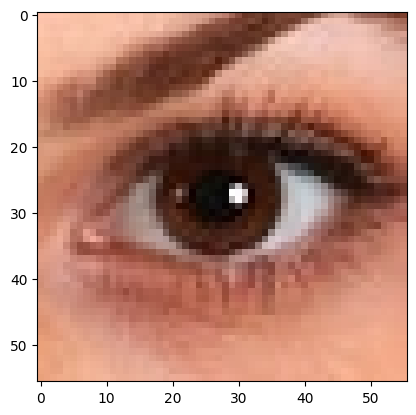

In [5]:
print(eyes_female['0011'].reshape(img_size,img_size,3).shape)
plt.imshow(Image.fromarray(eyes_female['0011'].reshape(img_size,img_size,3)))
plt.show()

Looks good - the shape of `(56, 56, 3)` indicates an 3-dimensional array representing RGB with no alpha channel.

### 3.2. Class Labels: <a name="class"></a>

Now, we should add the class labels to each image. This was made easier by keeping the two genders separate for now.

In [6]:
eyes_female_df = pd.DataFrame(eyes_female.items(), columns = ['eye_d', 'rgb_flat'])
eyes_male_df = pd.DataFrame(eyes_male.items(), columns = ['eye_d', 'rgb_flat'])

eyes_female_df['sex'] = 0
eyes_male_df['sex'] = 1

### 3.3. Balance Dataset: <a name="balance"></a>

Now, we can see if the target variable is balanced or not.

In [7]:
print(f'Female Sample Size: {len(eyes_female_df)}')
print(f'Male Sample Size: {len(eyes_male_df)}')

Female Sample Size: 2591
Male Sample Size: 3173


Ok this shows a fairly unbalanced dataset. This is important mind for when we do the train / val / test set splits and model evaluations.

In fact, to simplify things, we can balance the dataset by removing the extra male images by randomly sampling the male eyes without replacement up to the number of female eyes.

Then, the two dataframes will be combined into one.

In [8]:
# Balance classes, limiting the number of male eyes.
eyes_male_df = eyes_male_df.sample(n = len(eyes_female_df), random_state = 11, replace = False)

# Create dataframe with mixed sexes.
eyes_df = pd.concat([eyes_female_df, eyes_male_df]).reset_index(drop = True)
eyes_df

eye_d                                           rgb_flat  sex
0     0823  [216, 170, 136, 214, 168, 134, 212, 166, 133, ...    0
1     4217  [141, 77, 49, 140, 76, 48, 138, 77, 48, 137, 7...    0
2     5109  [244, 215, 199, 235, 206, 190, 165, 133, 118, ...    0
3     4571  [237, 210, 193, 234, 207, 190, 234, 205, 189, ...    0
4     1409  [175, 143, 130, 173, 141, 128, 172, 139, 130, ...    0
...    ...                                                ...  ...
5177  0579  [151, 112, 104, 149, 110, 103, 153, 114, 109, ...    1
5178  5191  [210, 210, 210, 212, 212, 212, 209, 209, 209, ...    1
5179  0425  [163, 118, 87, 164, 119, 88, 170, 125, 94, 166...    1
5180  5491  [66, 44, 47, 48, 26, 30, 46, 25, 31, 44, 25, 3...    1
5181  0821  [221, 159, 138, 221, 158, 138, 217, 150, 130, ...    1

[5182 rows x 3 columns]

### 3.4. Image Normalization: <a name="norm"></a>

It's important to normalize the image pixel intensities for use in the neural networks.

In [9]:
eyes_df['norm_flat'] = eyes_df['rgb_flat'] / 255

In [10]:
# Function to reshape arrays for processes / models that require image array.
def flat_to_array(flat_array):
    '''
    Takes a dataframe column (series) and reshapes flat array to image array (H x W x C).
    '''
    return flat_array.reshape(img_size,img_size,3)

## 4. Train / Val / Test Split <a name="split"></a>

---

Split 
- Train = 70%
- Validation = 18%
- Test = 12%

In [11]:
# Train and Test
X_train, X_test = train_test_split(eyes_df, test_size = 0.30, shuffle = True, stratify = eyes_df.sex, random_state = 11)
# Validation from Test
X_test, X_val = train_test_split(X_test, test_size = 0.60, shuffle = True, stratify = X_test.sex, random_state = 11)

# Create y.
y_train = X_train.sex
y_val = X_val.sex
y_test = X_test.sex

# Drop y from X.
X_train = X_train.drop(columns = ['sex'])
X_val = X_val.drop(columns = ['sex'])
X_test = X_test.drop(columns = ['sex'])

print(f'Train Set Size: {len(X_train)}')
print(f'Validation Set Size: {len(X_val)}')
print(f'Test Set Size: {len(X_test)}')
print('\n##################\n')
print('Target Class Balance:')
print('----Train:\n', y_train.value_counts())
print('----Validation:\n', y_val.value_counts())
print('----Test:\n', y_test.value_counts())

Train Set Size: 3627
Validation Set Size: 933
Test Set Size: 622

##################

Target Class Balance:
----Train:
 sex
0    1814
1    1813
Name: count, dtype: int64
----Validation:
 sex
1    467
0    466
Name: count, dtype: int64
----Test:
 sex
0    311
1    311
Name: count, dtype: int64


## 5. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

In [12]:
# Colors for the target classes to stay consistent.
cmap_sex = {'Female' :'#439A86', 'Male': '#423e80'}

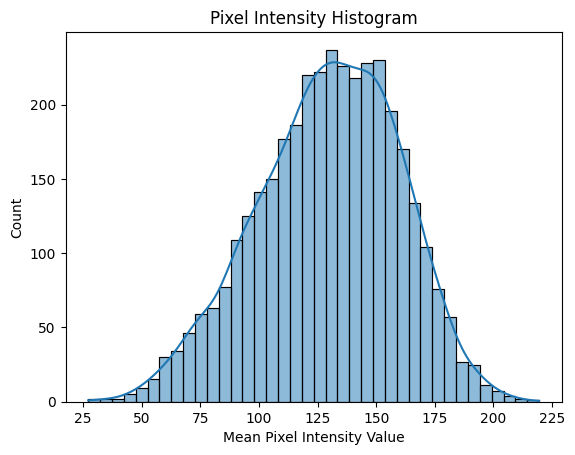

In [13]:
# Find the mean pixel intensity of each image (down to one value along all axes).
mean_intensity = X_train.rgb_flat.apply(flat_to_array).apply(np.mean)

sns.histplot(mean_intensity, binwidth = 5, kde = True)
plt.xlabel('Mean Pixel Intensity Value')
plt.title('Pixel Intensity Histogram')
plt.show()

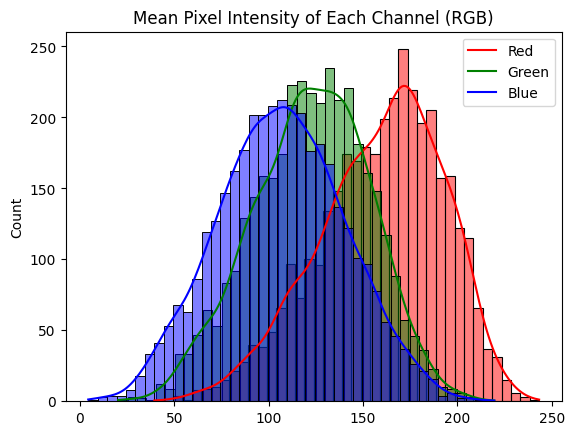

In [14]:
mean_intensity_rgb = np.stack(X_train.rgb_flat.apply(flat_to_array).apply(np.mean, axis = 1).apply(np.mean, axis = 0).to_numpy())

# Plot the distribution of the mean intensities of individual RGB channels.
rgb_dict = {0:'Red', 1:'Green', 2:'Blue'}
for i in rgb_dict.keys():
    sns.histplot(mean_intensity_rgb[:,i], color = rgb_dict[i], binwidth = 5, kde = True)#, ax = ax[i])
plt.title('Mean Pixel Intensity of Each Channel (RGB)')
plt.legend(list(rgb_dict.values()))
plt.show()

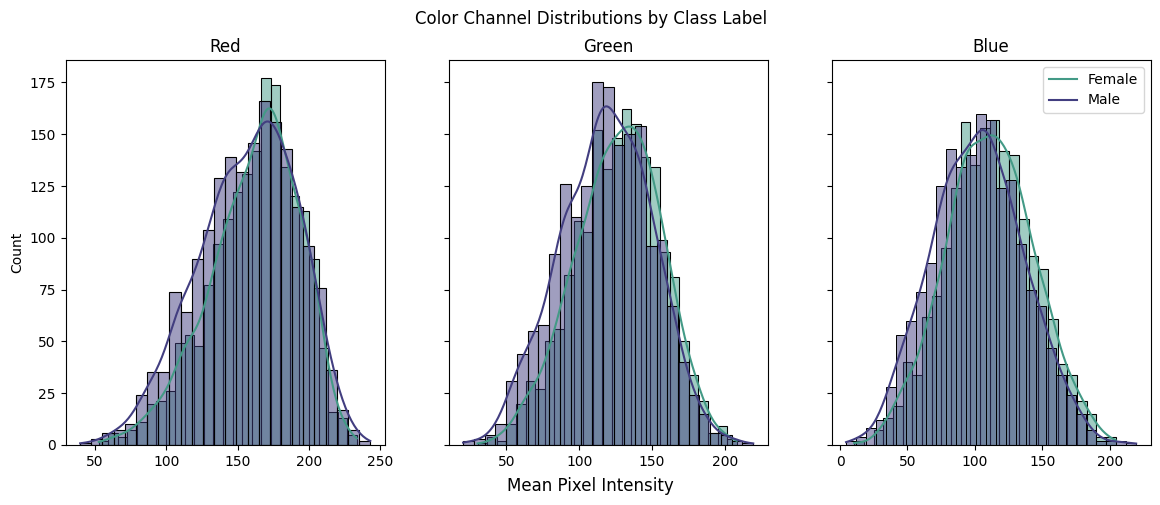

In [15]:
# Create a mask of the target class.
mask_sex = y_train == 0

# Plot the distribution of the mean intensities of individual channels in both Males and Females.
fig, ax = plt.subplots(1, 3, figsize = (14, 5), sharey = True)
for i in range(3):
    # Female
    sns.histplot(mean_intensity_rgb[:,i][mask_sex], kde = True, color = cmap_sex['Female'], ax = ax[i])
    # Male
    sns.histplot(mean_intensity_rgb[:,i][~mask_sex], kde = True, color = cmap_sex['Male'], ax = ax[i])
    ax[i].set_title(f'{rgb_dict[i]}')
fig.supxlabel('Mean Pixel Intensity')
fig.suptitle('Color Channel Distributions by Class Label')
plt.legend(['Female', 'Male'])
plt.show()

## 6. Image Transformations / Augmentations <a name="transforms"></a>

---

While we did import the images into memory before, utilizing a dataloader and applying random image augmentations at each batch call should increase performance of the models. These transformations will only be performed on the training set and will introduce much more diversity than the original dataset.

The following augmentations will be performed randomly:
- Random Flip in the horizontal direction. Vertical isn't necessary here as it's rare that these models will see an eye in that orientation.
- Random Rotation. This will be very important to help the models become rotation invariant by helping them generalize much better than the original dataset which likely has an uneven distribution of eye angles.
- Random Crop. Will select a random crop of the image and interpolate the pixels to maintain the same image size. This will help account for different eye positions.
- Random Brightness. Again, this is helpful because the original dataset has varying light qualities.
- Random Saturation. Same as brightness, but with color saturation.

Develop Image Transformation/Augmentation Function for training set.

(Random intensity, horizontal and vertical mirroring, rotations, subset crop of image + padding, etc)

In [16]:
BATCH_SIZE = 16

In [17]:
# Create a dataset with images and labels together.
# Train.
X_ds_train = tf.data.Dataset.from_tensor_slices(np.stack(X_train.norm_flat.values).reshape(len(X_train), img_size, img_size, 3))
y_ds_train = tf.data.Dataset.from_tensor_slices(y_train.values)

ds_train = tf.data.Dataset.zip((X_ds_train, y_ds_train))

# Val.
X_ds_val = tf.data.Dataset.from_tensor_slices(np.stack(X_val.norm_flat.values).reshape(len(X_val), img_size, img_size, 3))
y_ds_val = tf.data.Dataset.from_tensor_slices(y_val.values)

ds_val = tf.data.Dataset.zip((X_ds_val, y_ds_val))

In [18]:
# Transformation object.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomCrop(img_size, img_size),
    tf.keras.layers.RandomBrightness(0.4, value_range = (0, 1)),
    # Random saturation using lambda.
    tf.keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower = 0, upper = 3))
    ])

# Autotune to set buffer size.
AUTOTUNE = tf.data.AUTOTUNE

# Function to setup the transformations within the dataloader.
def prepare(ds, shuffle = False, augment = False):
    if shuffle:
        ds = ds.shuffle(1000)

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training = True), y), num_parallel_calls = AUTOTUNE)
    
  # Prefetch buffer necessary here to ensure proper loading during training.
    return ds.prefetch(buffer_size = AUTOTUNE)

In [19]:
# Training Set Final
ds_train_transformed = prepare(ds_train, shuffle = True, augment = True)
ds_train_transformed = ds_train_transformed.batch(BATCH_SIZE)

# Validation Set Final
ds_val = prepare(ds_val, shuffle = False, augment = False)
ds_val = ds_val.batch(BATCH_SIZE)

# For comparison to transformed training.
ds_train = prepare(ds_train, shuffle = True, augment = False)
ds_train = ds_train.batch(BATCH_SIZE)

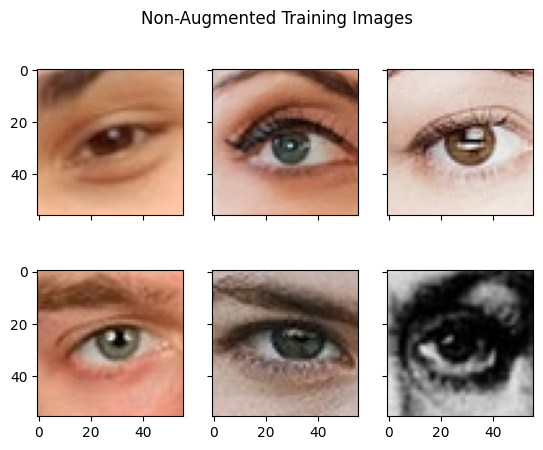

In [20]:
for img, label in ds_train:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    img = (img.numpy() * 255).astype(np.uint8)
    for i in range(6):
        ax[i // 3, i % 3].imshow(img[i])
    fig.suptitle('Non-Augmented Training Images')
    break

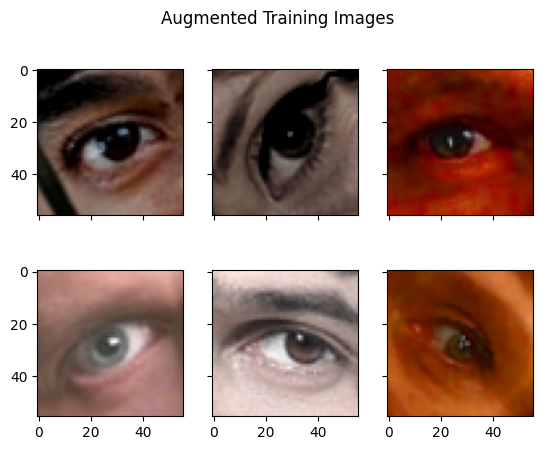

In [21]:
for img, label in ds_train_transformed:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    img = (img.numpy() * 255).astype(np.uint8)
    for i in range(6):
        ax[i // 3, i % 3].imshow(img[i])
    fig.suptitle('Augmented Training Images')
    break

## 7. Models <a name="models"></a>

---

As was mentioned above, since the dataset has been class balanced, the metric we will evaluate all models is accuracy. Of course, the models will be trained using the training set and will utilize the validation set as the evaluation set during training. Validation set accuracy scores will be output after model training, and the final test set scores will be calculated in the Results section (9).

Also, each model will be trained on the training set WITH image augmentation, but also trained on the original dataset with the same dataloader settings, just without augmentations, so we can compare the performance of including these transformations at the end.

### 7.0. Model Helper Functions: <a name="helper"></a>

Here we will add a few functions to help visualize how the model perform during training.

In [66]:
def set_region_overlay(model_history_df, x_offset):
    x_mid = ((model_history_df.index.stop-1) + model_history_df.val_loss.idxmin()) / 2
    plt.text(x = x_mid - x_offset,
             y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
             s = 'Early Stop',
             rotation = 'horizontal',
             weight = 'extra bold',
             fontsize = 'large',
             antialiased = True,
             alpha = 1,
             c = 'white',
             bbox = dict(facecolor = 'black', edgecolor = 'black', boxstyle = 'round', alpha = 0.5))
    return None

def plot_TF_training_history(model_history_df, plot_title = None):

    # Find all epochs that callback ReduceLROnPlateau() occurred.
    lr_change = model_history_df.learning_rate.shift(-1) != model_history_df.learning_rate

    # Create color map and lines style map for train/val
    plot_maps = {'cmap': {'accuracy': '#653096',
                        'loss': '#653096',
                        'val_accuracy': '#004a54',
                        'val_loss': '#004a54'},
                'dashmap': {'accuracy': '',
                            'loss': (2,1),
                            'val_accuracy': '',
                            'val_loss': (2,1)}}

    # Plot
    fig, ax = plt.subplots(figsize = (10,6))
    ax = sns.lineplot(model_history_df.drop(columns = ['learning_rate']).iloc[1:], palette = plot_maps['cmap'], dashes = plot_maps['dashmap'])
    ax.set_xlabel('Epoch')

    # Create secondary x-axis for Learning Rate changes.
    sec_ax = ax.secondary_xaxis('top')
    sec_ax.set_xticks(model_history_df[lr_change].index[:-1])
    sec_ax.set_xticklabels([f'{x:.1e}' for x in model_history_df[lr_change].learning_rate[1:]])
    sec_ax.tick_params(axis = 'x', which = 'major', labelsize = 7)
    sec_ax.set_xlabel('Learning Rate Reductions')

    # Create vertical line for each LR change.
    for epoch in (model_history_df[lr_change].index[:-1]):
        plt.axvline(x = epoch, c = '#d439ad', ls = (0, (5,5)))
    # Create lines for best epoch/val_loss.
    plt.axvline(x = (model_history_df.val_loss.idxmin()), c = '#f54260', ls = (0, (3,1,1,1)))
    plt.axhline(y = (model_history_df.val_loss.min()), c = '#f54260', alpha = 0.3, ls = (0, (3,1,1,1)))
    # Grey out epochs after early stop.
    plt.axvspan(model_history_df.val_loss.idxmin(), model_history_df.index.stop-1, facecolor = 'black', alpha = 0.25)
    plt.margins(x = 0)
    set_region_overlay(model_history_df, 5)

    if plot_title is not None:
        fig.suptitle(plot_title)

    plt.legend(loc = 'center')
    plt.show()
    return None

### 7.1. Baseline Models: <a name="baseline"></a>

It's always important to formulate a baseline model to compare all models to.

**Random Chance Baseline**

Only two classes here, so the random chance baseline is 50%.

In [23]:
1/2

0.5

**K-Nearest Neighbors (KNN) as Baseline**

Since this dataset contains all eyes that are mostly centered in the same position, KNN is a quick and easy model to implement and compare more complex methods against.

In [24]:
# TODO: Implement KNN discriminant plot from sklearn.
mod_knn = KNeighborsClassifier(n_neighbors = 2, weights = 'distance', algorithm = 'brute', p = 2)
mod_knn.fit(np.stack(X_train.norm_flat), y_train)

y_pred_val_knn = mod_knn.predict(np.stack(X_val.norm_flat))
accuracy_score(y_val, y_pred_val_knn)

0.7738478027867095

77.38% accuracy on the validation set is pretty impressive for a model only using distance metrics on pixel intensities. This surprise performance is likely because most eyes in this dataset are in relatively the same position.

Now the prediction on the test set will be performed and saved for the results section after all tuning is completed.

In [25]:
# Predict on the test set.
y_pred_knn_proba = mod_knn.predict_proba(np.stack(X_test.norm_flat))
y_pred_knn = mod_knn.predict(np.stack(X_test.norm_flat))

### 7.2. Deep Learning Models: <a name="deep"></a>

#### 7.2.1. Shallow Feedforward Neural Network (FNN): <a name="fnn"></a>

Given that there are only two classes and one type of image (photos of eyes), it may be overlooked that a simple shallow dense network can potentially perform quite well on this classification task (see MNIST numbers dataset). While, it likely won't outperform a Convolutional Neural Network (CNN), it may be worth it to train what we'll call an FNN here to compare it to the CNN-based models.

We'll use two layers of dense nodes with ReLU activation functions and a light dropout (to mitigate overfitting) applied after activation of each of those two layers.

In [26]:
def build_fnn(input_shape = (img_size, img_size, 3)):
    mod_fnn = tf.keras.Sequential([
        tf.keras.Input(shape = input_shape, name = 'Imput Image'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(128),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, name = 'Predictions')])
    return mod_fnn

mod_fnn = build_fnn()
mod_fnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 9408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,817,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictions (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,883,330 (18.63 MB)

 Trainable params: 4,883,330 (18.63 MB)

 Non-trainable params: 0 (0.00 B)

Model Specifications:

- Loss Function: Sparse Categorical using Cross-Entropy
- Optimizer: Adam
- Callbacks:
    - Early Stopping
    - Adjust Learning Rate on Loss Plateau

Below we can see the two "Callbacks" initialized. These are very important for how these models are being trained.

Details:
1. Early Stopping:
    - We need a way to train the model a sufficient amount of epochs, but as validation loss is measured and if this loss stops improving over, in this case, 25 epochs -- the model will stop training and revert weights to values at the best epoch (lowest validation loss).
2. Reduce Learning Rate on Plateau:
    - In need of a method to appropriately adjust how fast the model performs its gradient descent, this appropriately named callback does just that.
    - Patience is set at 5: As the validation loss reduces but eventually stalls (plateaus) for 5 consecutive epochs, the learning rate will be reduced by a factor of 50%. This reduction in learning rate then has a cooldown period where it won't reduce for 8 epochs.

Both of these callbacks and all of their parameters were used and iteratively adjusted during training of all subsequent models.

In [27]:
loss_fx = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # Integer labels.
optimizer_param = 'adam'
val_freq = 1
n_epochs = 250
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 25, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                         factor = 0.5,
                                                         patience = 5,
                                                         cooldown = 8,
                                                         min_lr = 0.0001,
                                                         verbose = 1)

In [28]:
mod_fnn.compile(optimizer = optimizer_param, loss = loss_fx, metrics = ['accuracy'])

mod_fnn_hist = mod_fnn.fit(
    ds_train_transformed,
    batch_size = BATCH_SIZE,
    epochs = n_epochs,
    verbose = "auto",
    callbacks = [early_stop, reduce_lr_plateau],
    #validation_split = 0.0,
    validation_data = ds_val,
    shuffle = True,
    class_weight = None,
    sample_weight = None,
    initial_epoch = 0,
    steps_per_epoch = None,
    validation_steps = None,
    validation_batch_size = None,
    validation_freq = val_freq)

Epoch 1/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5278 - loss: 2.1671 - val_accuracy: 0.5927 - val_loss: 0.6472 - learning_rate: 0.0010
Epoch 2/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6062 - loss: 0.6833 - val_accuracy: 0.6056 - val_loss: 0.6615 - learning_rate: 0.0010
Epoch 3/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5961 - loss: 0.6758 - val_accuracy: 0.5756 - val_loss: 0.6795 - learning_rate: 0.0010
Epoch 4/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6171 - loss: 0.6577 - val_accuracy: 0.5005 - val_loss: 0.7131 - learning_rate: 0.0010
Epoch 5/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5448 - loss: 0.6892 - val_accuracy: 0.6742 - val_loss: 0.6361 - learning_rate: 0.0010
Epoch 6/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6135 - loss: 0.6547 - val_accuracy: 0.7085 - val_loss: 0.6061 - learning_rate: 0.0010
Epoch 7/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6528 - l

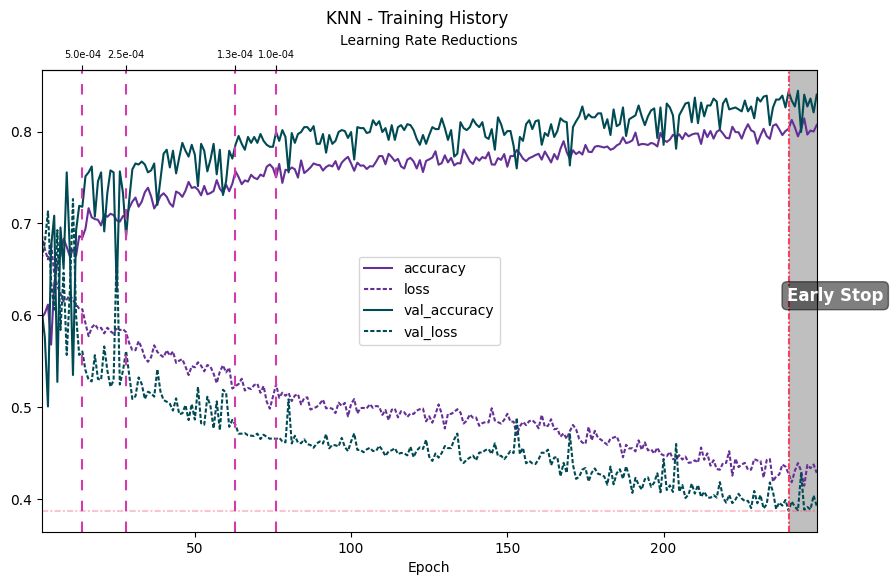

In [29]:
# Create dataframe of model fit history.
mod_fnn_hist_df = pd.DataFrame().from_dict(mod_fnn_hist.history, orient = 'columns')

plot_TF_training_history(mod_fnn_hist_df, 'KNN - Training History')

This looks great, and the model didn't overfit to the training data. The model seems slightly unstable, but that is to be expected especially with the random augmentations being applied to the training data at each epoch because this type of model is not invariant to the types of augmentations being performed.

Looking at the training history here, the model could likely be trainied for a few more epochs, but through tuning it I know that this is about as stable as it gets and has essentially converged here so we will move on.

In [30]:
y_pred_val_fnn_proba = mod_fnn.predict(ds_val, verbose = "auto", callbacks = None)
y_pred_val_fnn = y_pred_val_fnn_proba.argmax(axis = 1)

accuracy_score(y_val, y_pred_val_fnn)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.8435155412647374

84.35% accuracy on the validation set is a great score for image classification using only dense layers!

Now the prediction on the test set will be performed and saved for the results section after all tuning is completed.

In [31]:
y_pred_fnn_proba = mod_fnn.predict(np.stack(X_test.norm_flat.apply(flat_to_array)), verbose = "auto", callbacks = None)
y_pred_fnn = y_pred_fnn_proba.argmax(axis = 1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


##### Non-Augmented Training

Train the same model but use the training set that is not augmented/transformed for comparison at the end. Muted outputs for notebook clarity.

In [32]:
mod_fnn_no_aug = build_fnn()
mod_fnn_no_aug.compile(loss = loss_fx,
                optimizer = optimizer_param,
                metrics = ['accuracy'])

# Callbacks to use (same as above):
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 25, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, cooldown = 8, min_lr = 0.0001, verbose = 0)

mod_fnn_no_aug_hist = mod_fnn_no_aug.fit(ds_train,
                           batch_size = BATCH_SIZE,
                           epochs = n_epochs,
                           verbose = 0,
                           callbacks = [early_stop, reduce_lr_plateau],
                           validation_split = 0.0,
                           validation_data = ds_val,
                           shuffle = True,
                           class_weight = None,
                           sample_weight = None,
                           initial_epoch = 0,
                           steps_per_epoch = None,
                           validation_steps = None,
                           validation_batch_size = None,
                           validation_freq = val_freq)

y_pred_val_fnn_no_aug_proba = mod_fnn_no_aug.predict(ds_val, verbose = 0, callbacks = None)
y_pred_val_fnn_no_aug = y_pred_val_fnn_no_aug_proba.argmax(axis = 1)

y_pred_fnn_no_aug_proba = mod_fnn_no_aug.predict(np.stack(X_test.norm_flat.apply(flat_to_array)), verbose = 0, callbacks = None)
y_pred_fnn_no_aug = y_pred_fnn_no_aug_proba.argmax(axis = 1)

Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 75.


We can see training without the variance that randomly augmenting introduces into the dataset, heavily reduces the training time. This model reverted back to epoch 75 while the previous model, with image augmentations, trained until 241. We'll see how this effects performance in the results section.

#### 7.2.2. Deep-ish Convolutional Neural Network (CNN): <a name="cnn"></a>

Model Specifications:

- Loss Function: Sparse Categorical using Cross-Entropy
- Optimizer: Stochastic Gradient Descent (SGD)
- Callbacks:
    - Early Stopping
    - Adjust Learning Rate on Loss Plateau

The model below showcases the benefits of stacking multiple 3x3 convolutional layers instead of utilizing larger kernel sizes. 

Consider a network using the same number of filters with larger kernel sizes (such as 32 filters of 5x5 and 96 filters of 7x7) would require 20,473,314 trainable parameters. This model, by distributing the same number of filters across multiple layers of 3x3 kernels, achieves the same receptive field with only 7,501,106 parameters. This significant reduction is due to the fact that larger kernels introduces redundant parameter calculations without adding unique value to the model's learning capability.

An additional advantage of using multiple 3x3 kernels is the introduction of activation functions between layers, which increases the model’s non-linearity and allows it to capture more complex patterns in the data compared to larger single-layer kernels.

These factors allow the use of much deeper networks while maintaining computational efficiency, which is why modern architectures predominantly use stacked 3x3 kernels.

In [33]:
def build_cnn(input_shape = (img_size, img_size, 3)):

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape = input_shape, name = 'Image Array'),
        # First block (2).
        tf.keras.layers.Conv2D(16, kernel_size = (3,3), padding = 'same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(16, kernel_size = (3,3), padding = 'same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D((2,2), strides = 2),

        # Second block (3)
        tf.keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D((2,2), strides = 2),

        # Classifier block (2).
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, name = 'Predictions')])
    return model

mod_cnn = build_cnn()
mod_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 56, 56, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     6,423,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictions (Dense)             │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,501,106 (28.61 MB)

 Trainable params: 7,501,106 (28.61 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
loss_fx = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # Integer labels.
optimizer_param = 'sgd'
val_freq = 1
n_epochs = 300
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 40, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                         factor = 0.5,
                                                         patience = 5,
                                                         cooldown = 8,
                                                         min_lr = 0.0001,
                                                         verbose = 1)

In [35]:
mod_cnn.compile(loss = loss_fx,
                optimizer = optimizer_param,
                metrics = ['accuracy'])

mod_cnn_hist = mod_cnn.fit(ds_train_transformed,
                           batch_size = BATCH_SIZE,
                           epochs = n_epochs,
                           verbose = "auto",
                           callbacks = [early_stop, reduce_lr_plateau],
                           validation_split = 0.0,
                           validation_data = ds_val,
                           shuffle = True,
                           class_weight = None,
                           sample_weight = None,
                           initial_epoch = 0,
                           steps_per_epoch = None,
                           validation_steps = None,
                           validation_batch_size = None,
                           validation_freq = val_freq)

Epoch 1/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5011 - loss: 0.6938 - val_accuracy: 0.5102 - val_loss: 0.6913 - learning_rate: 0.0100
Epoch 2/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5154 - loss: 0.6925 - val_accuracy: 0.5852 - val_loss: 0.6893 - learning_rate: 0.0100
Epoch 3/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5191 - loss: 0.6922 - val_accuracy: 0.6120 - val_loss: 0.6847 - learning_rate: 0.0100
Epoch 4/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5469 - loss: 0.6889 - val_accuracy: 0.6452 - val_loss: 0.6814 - learning_rate: 0.0100
Epoch 5/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5495 - loss: 0.6881 - val_accuracy: 0.6710 - val_loss: 0.6748 - learning_rate: 0.0100
Epoch 6/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5820 - loss: 0.6793 - val_accuracy: 0.7063 - val_loss: 0.6572 - learning_rate: 0.0100
Epoch 7/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6005 - l

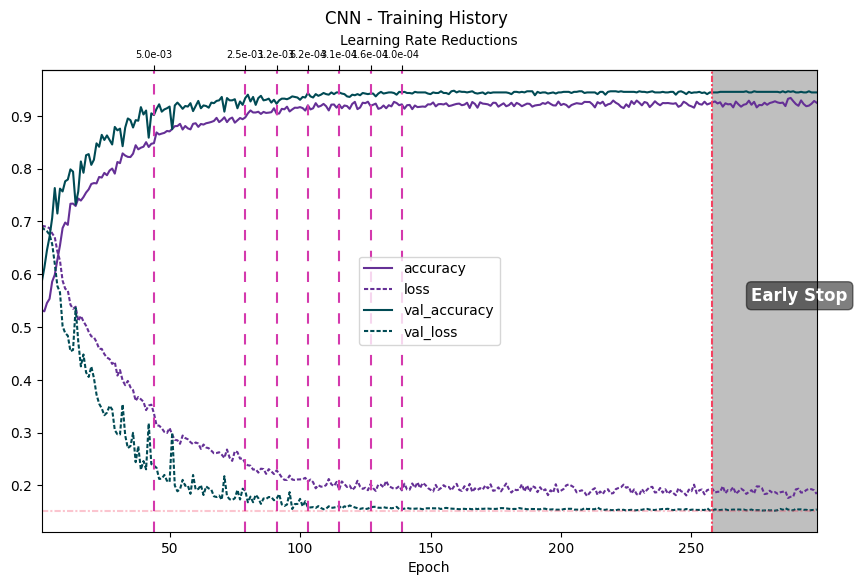

In [67]:
# Create dataframe of model fit history.
mod_cnn_hist_df = pd.DataFrame().from_dict(mod_cnn_hist.history, orient = 'columns')

plot_TF_training_history(mod_cnn_hist_df, 'CNN - Training History')

This looks great, we can see how the model stabilizes and converges nicely without overfitting, still gaining slight improvements all the way until epoch 259.  During model building and tuning it was unclear if batch normalization layers were necessary in this network, but in the end it didn't seem necessary.

Looking at the training loss line we can see how much the loss oscillates until around 100 epochs this is likely due to the random image augmentations, helping create a more generalizable and robust model.

In [37]:
y_pred_val_cnn_proba = mod_cnn.predict(np.stack(X_val.norm_flat.apply(flat_to_array)), verbose = "auto", callbacks = None)
y_pred_val_cnn = y_pred_val_cnn_proba.argmax(axis = 1)

accuracy_score(y_val, y_pred_val_cnn)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


0.9442658092175777

The model achieves a 94.43% accuracy score on the validation set.

In [38]:
y_pred_cnn_proba = mod_cnn.predict(np.stack(X_test.norm_flat.apply(flat_to_array)), verbose = "auto", callbacks = None)
y_pred_cnn = y_pred_cnn_proba.argmax(axis = 1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


##### Non-Augmented Training

Train the same model but use the training set that is not augmented/transformed for comparison at the end. Muted outputs for clarity.

In [39]:
mod_cnn_no_aug = build_cnn()

# Callbacks to use (same as above):
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 40, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, cooldown = 8, min_lr = 0.0001, verbose = 0)
optimizer_param = tf.keras.optimizers.SGD(learning_rate = 0.01)

mod_cnn_no_aug.compile(loss = loss_fx,
                optimizer = optimizer_param,
                metrics = ['accuracy'])

mod_cnn_no_aug_hist = mod_cnn_no_aug.fit(ds_train,
                           batch_size = BATCH_SIZE,
                           epochs = n_epochs,
                           verbose = 0,
                           callbacks = [early_stop, reduce_lr_plateau],
                           validation_split = 0.0,
                           validation_data = ds_val,
                           shuffle = True,
                           class_weight = None,
                           sample_weight = None,
                           initial_epoch = 0,
                           steps_per_epoch = None,
                           validation_steps = None,
                           validation_batch_size = None,
                           validation_freq = val_freq)

y_pred_val_cnn_no_aug_proba = mod_cnn_no_aug.predict(ds_val, verbose = 0, callbacks = None)
y_pred_val_cnn_no_aug = y_pred_val_cnn_no_aug_proba.argmax(axis = 1)

y_pred_cnn_no_aug_proba = mod_cnn_no_aug.predict(np.stack(X_test.norm_flat.apply(flat_to_array)), verbose = 0, callbacks = None)
y_pred_cnn_no_aug = y_pred_cnn_no_aug_proba.argmax(axis = 1)

Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 28.


Interestingly the model without augmented training images stops training and reverts back to weights from epoch 28.

#### 7.2.3. Deep Convolutional Neural Network (DCNN): <a name="dcnn"></a>

Next, I would like to try to implement a model that is tried and tested on image classification tasks-ResNet50- which is the perfect mix of depth and efficiency here. Anything deeper would likely be overkill since the images input are only 56x56.

The benefit of the ResNet architecture is within it's name, Residual connections, sometimes called skip connections. These connections connect/concatenate outputs of earlier layers to inputs of later layers, skipping over a number of layers (in this case 2). This effectively combats the issue of vanishing gradients by allowing the network to skip over connections that hurt the performance of the classifier.

This model below was largely built from the source code for TensorFlow's ResNet50 from https://github.com/tensorflow/models/tree/master/official/vision and elsewhere. Slight alterations were made to the original architecture but it is mostly the same. Notably, I opted for a smaller kernel size in the first layer as this dataset's images are already very small. There are pre-trained versions of ResNet out there (and within Tensorflow for that matter), but I will build and train a new one for a more equal comparison between this and my previous, much shallower model.

In [40]:
# Inspired by ResNet 50 https://github.com/tensorflow/models/tree/master/official/vision
# Residual function to set skip connections. Downsample to reduce dimension.
def residual_block(x, filters, downsample = False):
    shortcut = x
    strides = (2, 2) if downsample else (1, 1)

    # First convolution layer.
    x = tf.keras.layers.Conv2D(filters, kernel_size = (3, 3), strides = strides, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Second convolution layer.
    x = tf.keras.layers.Conv2D(filters, kernel_size = (3, 3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    #  Add convolution if downsample == True.
    if downsample:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size = (1, 1), strides = (2, 2), padding = 'same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # Add the shortcut (input) to the output.
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x

# Build model.
def build_dcnn(input_shape = (img_size, img_size, 3)):
    inputs = tf.keras.Input(shape = input_shape)

    # Initial convolutional layer. Reduced kernel size here from default 7,7 because the input images are small.
    x = tf.keras.layers.Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same')(x)

    # First residual block (3 blocks).
    for _ in range(3):
        x = residual_block(x, 64)

    # Second residual block (4 blocks).
    x = residual_block(x, 128, downsample = True)
    for _ in range(3):
        x = residual_block(x, 128)

    # Third residual block (6 blocks).
    x = residual_block(x, 256, downsample = True)
    for _ in range(5):
        x = residual_block(x, 256)

    # Fourth residual block (3 blocks).
    x = residual_block(x, 512, downsample = True)
    for _ in range(2):
        x = residual_block(x, 512)

    # Global average pooling layer and final output prediction.
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(2, name = 'Predictions')(x)

    # Create model.
    model = tf.keras.Model(inputs, outputs)
    return model

# Finally, build the model.
mod_dcnn = build_dcnn(input_shape=(img_size, img_size, 3))
mod_dcnn.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 56, 56, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │      4,864 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 14, 14,    │          0 │ re_lu_18[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 14, 14,    │     36,928 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 14, 14,    │     36,928 │ re_lu_19[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 14, 14,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 14, 14,    │     36,928 │ re_lu_20[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 14, 14,    │     36,928 │ re_lu_21[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_14[0][0] 

 Total params: 21,306,626 (81.28 MB)

 Trainable params: 21,289,602 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

As expected, that's a lot of layers. Also as another example of the power of stacked 3x3 layers, note the number of trainable parameters here - 21,289,602. That's almost the same amount as my the previous model's architecture with 5x5 and 7x7 kernels!

As with all other models the same callbacks are used, but were slightly modified to suit this network.

In [41]:
# Using similar loss, optimizer, and callbacks here.
loss_fx = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # Integer labels.
optimizer_param = 'sgd'
val_freq = 1
n_epochs = 300
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                         factor = 0.5,
                                                         patience = 5,
                                                         cooldown = 8,
                                                         min_lr = 0.0001,
                                                         verbose = 1)

In [42]:
mod_dcnn.compile(loss = loss_fx,
                optimizer = optimizer_param,
                metrics = ['accuracy'])

mod_dcnn_hist = mod_dcnn.fit(ds_train_transformed,
                           batch_size = BATCH_SIZE,
                           epochs = n_epochs,
                           verbose = "auto",
                           callbacks = [early_stop, reduce_lr_plateau],
                           validation_split = 0.0,
                           validation_data = ds_val,
                           shuffle = True,
                           class_weight = None,
                           sample_weight = None,
                           initial_epoch = 0,
                           steps_per_epoch = None,
                           validation_steps = None,
                           validation_batch_size = None,
                           validation_freq = val_freq)

Epoch 1/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 240ms/step - accuracy: 0.5159 - loss: 1.3220 - val_accuracy: 0.6120 - val_loss: 0.6770 - learning_rate: 0.0100
Epoch 2/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.6021 - loss: 0.8050 - val_accuracy: 0.7138 - val_loss: 0.5994 - learning_rate: 0.0100
Epoch 3/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - accuracy: 0.6490 - loss: 0.6986 - val_accuracy: 0.7353 - val_loss: 0.5611 - learning_rate: 0.0100
Epoch 4/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - accuracy: 0.7088 - loss: 0.5964 - val_accuracy: 0.7771 - val_loss: 0.4710 - learning_rate: 0.0100
Epoch 5/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.7268 - loss: 0.5578 - val_accuracy: 0.7953 - val_loss: 0.4342 - learning_rate: 0.0100
Epoch 6/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.7410 - loss: 0.5364 - val_accuracy: 0.7599 - val_loss: 0.5030 - learning_rate: 0.0100
Epoch 7/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - accura

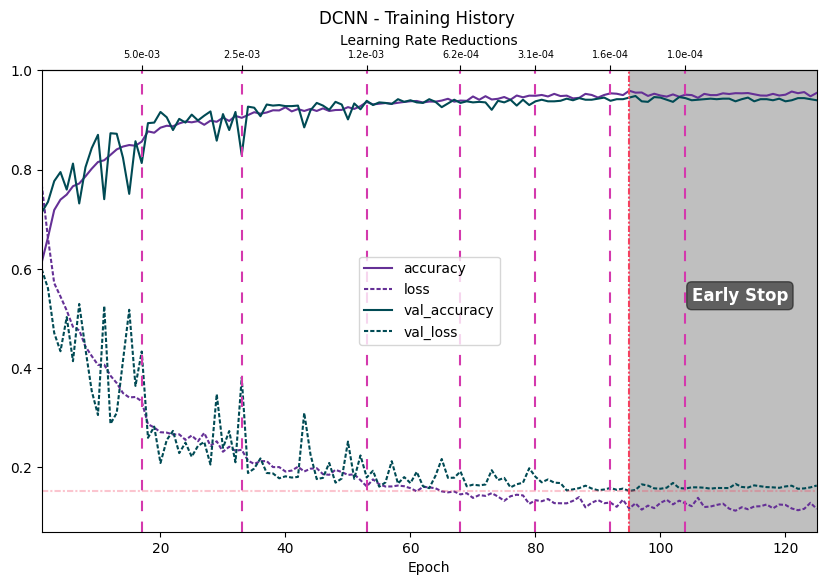

In [68]:
# Create dataframe of model fit history.
mod_dcnn_hist_df = pd.DataFrame().from_dict(mod_dcnn_hist.history, orient = 'columns')

plot_TF_training_history(mod_dcnn_hist_df, 'DCNN - Training History')

Impressive we can see that this model trains a little quicker than the previous one, ending at epoch 96. It also seems to just slightly overfit the training data but does utilize batch normalization between each convolution layer so the effects are mitigated.

Similarly we see a lot of oscillation in the performance in the beginning, eventually stabilizing around epoch 80.

In [44]:
y_pred_val_dcnn_proba = mod_dcnn.predict(np.stack(X_val.norm_flat.apply(flat_to_array)), verbose = "auto", callbacks = None)
y_pred_val_dcnn = y_pred_val_dcnn_proba.argmax(axis = 1)

accuracy_score(y_val, y_pred_val_dcnn)

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step


0.9453376205787781

94.53 accuracy on the validation set, just barely beating out the previous model. It will be interesting to see how they compare on the test set.

In [45]:
y_pred_dcnn_proba = mod_dcnn.predict(np.stack(X_test.norm_flat.apply(flat_to_array)), verbose = "auto", callbacks = None)
y_pred_dcnn = y_pred_dcnn_proba.argmax(axis = 1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


##### Non-Augmented Training

Train the same model but use the training set that is not augmented/transformed for comparison at the end. Muted outputs for clarity.

*Note: For a fair comparison, the learning rate of the optimizer was lowered from the default: 0.01 to 0.005 as the model was quickly overfitting the training data and the model was very unstable.*

In [46]:
mod_dcnn_no_aug = build_dcnn(input_shape=(img_size, img_size, 3))

optimizer_param = tf.keras.optimizers.SGD(learning_rate = 0.005)
mod_dcnn_no_aug.compile(loss = loss_fx,
                optimizer = optimizer_param,
                metrics = ['accuracy'])

# Callbacks to use (same as above):
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, cooldown = 8, min_lr = 0.0001, verbose = 1)

mod_dcnn_no_aug_hist = mod_dcnn_no_aug.fit(ds_train,
                           batch_size = BATCH_SIZE,
                           epochs = n_epochs,
                           verbose = 0,
                           callbacks = [early_stop, reduce_lr_plateau],
                           validation_split = 0.0,
                           validation_data = ds_val,
                           shuffle = True,
                           class_weight = None,
                           sample_weight = None,
                           initial_epoch = 0,
                           steps_per_epoch = None,
                           validation_steps = None,
                           validation_batch_size = None,
                           validation_freq = val_freq)

y_pred_val_dcnn_no_aug_proba = mod_dcnn_no_aug.predict(ds_val, verbose = 0, callbacks = None)
y_pred_val_dcnn_no_aug = y_pred_val_dcnn_no_aug_proba.argmax(axis = 1)

y_pred_dcnn_no_aug_proba = mod_dcnn_no_aug.predict(np.stack(X_test.norm_flat.apply(flat_to_array)), verbose = 0, callbacks = None)
y_pred_dcnn_no_aug = y_pred_dcnn_no_aug_proba.argmax(axis = 1)


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


## 8. Model Analysis and Feature Extraction Discussion: <a name="analysis"></a>

Now that the models have all been successfully trained and tuned, we can extract some fun and interesting information from different sections of the networks.

*Note: Unless otherwise specified all the analysis will be from the model (named CNN in this project) from section 7.2.2.* 

### 8.1. Visualize Model Filters: <a name="filters"></a>

By extracting the weights from the convolution layers, we can visualize the filter being applied to the input images. Here, this process is done to the first convolution layer, visualizing all 16 of the 3x3 kernels. For convenience, I plotted both the separated the RGB channels and the combined RGB filter.

Filter Shape: (3, 3, 3, 16)


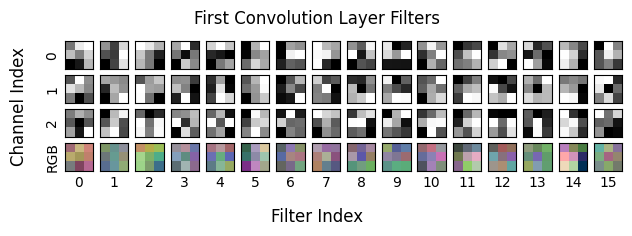

In [47]:
# Extract weights from first convolution layer. 
filters, biases = mod_cnn.layers[0].get_weights()
# Normalize values.
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print('Filter Shape:', filters.shape)

# Plot all filters and channels.
n_filters = filters.shape[3]
fig, ax = plt.subplots(4, n_filters, sharey = True, sharex = True)

for i in range(n_filters):
    filters_rgb = filters[:,:,:,i]
    for j in range(3):
        ax[j,i].imshow(filters_rgb[:,:,j], cmap = 'gray')
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])
        if i == 0:
            ax[j,i].set_ylabel(j)
    ax[3,i].imshow(filters_rgb)
    ax[3,i].set_xticks([])
    ax[3,i].set_yticks([])
    ax[3,i].set_xlabel(i)

ax[3,0].set_ylabel('RGB')
fig.supylabel('Channel Index')
fig.supxlabel('Filter Index', y = 0.25)
fig.suptitle('First Convolution Layer Filters', y = 0.7)
fig.tight_layout(h_pad = -14, w_pad = 0.5)
plt.show()

Note, pixels that are weighted more show up as white and pixels that are not show up as black.

Very similar to sobel filters and the like, these filters have been trained and weighted to pick up simple features like horizontal, vertical lines, angled lines, etc but of course these are represented in RGB space so it is a little more difficult to visually identify their purpose.


For a more human-comprehendible visualization -- next, we can jump ahead in the network to visualize the output of the convolution blocks as a whole by accessing the output at the max pool layer that is placed at the end of each convolution block. By passing through an image into the network, instead of the individual kernels we just saw, these outputs equate to the down-sampled filter view of the image.

The code will output as follows:
1. Take an unseen image (outside of all train/val/test datasets) and pass it through the model, recording the output at each layer.
    - Plot the unseen image for reference.
2. The second plot will be from the max pooling layer (layer 4) at the end of first block of 2 stacked 3x3 convolution layers.
    - This should output 16 - 28 x 28 weighted filters.
3. The third plot is from the max pooling layer (layer 11) at the end of the 2nd block of 3 stacked 3x3 convolutions.
    - This should output 32 - 14 x 14 weighted filters.

In [48]:
# Indexes of maxpool layers at end of conv blocks.
pool_idx = [4, 11]

# Retrieve output of each layer.
outputs = [mod_cnn.layers[i].output for i in pool_idx]
mod_cnn_feat = tf.keras.Model(inputs = mod_cnn.inputs,
                       outputs = outputs)

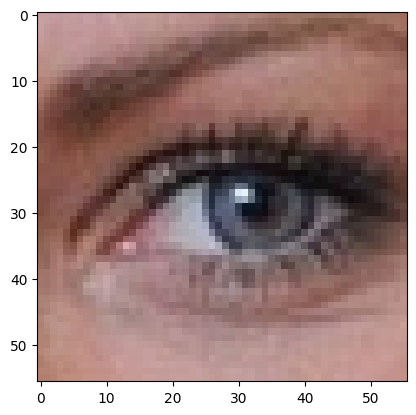

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Convolution Block 1
Filter Shape: (1, 28, 28, 16)


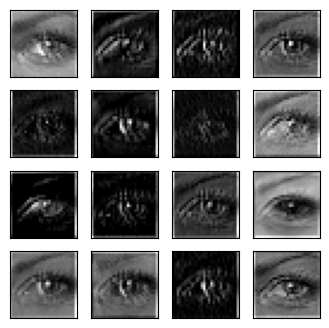

Convolution Block 2
Filter Shape: (1, 14, 14, 32)


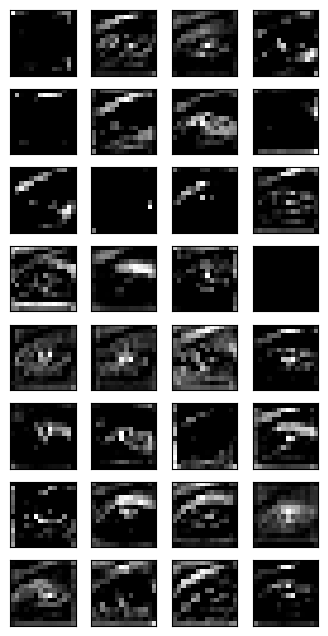

In [49]:
# Load unseen image.
img = Image.open('./Data/Female/186.jpg')
img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
img = np.asarray(img)
img = np.expand_dims(img, axis = 0)
plt.imshow(img[0,:,:,:])
plt.show()

# Retrieve feature maps for image.
feature_maps = mod_cnn_feat.predict(img)
# Get number of filters from shape of filters = (16, 32).
n_filters = [feature_maps[0].shape[3], feature_maps[1].shape[3]]
# Iterate through each feature map.
for i, fmap in enumerate(feature_maps):
    print(f'Convolution Block {i+1}')
    print('Filter Shape:', fmap.shape)
    fig, ax = plt.subplots(int(n_filters[i]/4), 4, figsize = ((4,4) if i == 0 else (4,8)))
    # Iterate through number of filters in current fmap layer.
    for j in range(n_filters[i]):
        # Plot each filter feature map.
        ax[j//4, j%4].set_xticks([])
        ax[j//4, j%4].set_yticks([])
        ax[j//4, j%4].imshow(fmap[0,:,:,j], cmap = 'gray')

    plt.show()

This is a great way to begin understanding what features the network has learned to weight heavily in its classification task.

- In the first convolution block output we can see several filters that capture various structures:
    - The iris and retina.
    - Masking the iris and retina but weight the skin around the eye.
    - Heavily weighting eye and eyelash edges.

- The last plot showing the last convolution block shows what would be expected of an activation map view. We can see a much more contrasted and simplified view of this image. Some filters seem to be capture:
    - Skin creases.
    - Eyebrows.
    - The skin above the eye but below the eyebrow.
    - Eye lashes.
    - General edge detection.
    - Combinations of hair and eyes.

### 8.2. Occlusion Sensitivity Plots: <a name="occlusion"></a>

Another method to determine by how much a model weights certain features is Occlusion Sensitivity. Occlusion sensitivity, put simply, occludes or covers portions of an input image and passes it through the model, tracking the changes in class probabilities and thus building a heatmap of important areas of the image. 

Two parameters are important in this process: The occluding patch size and the process by which the occlusion location is chosen.

You can implement this manually by randomly choosing occlusion locations, eventually processing each position, or even just iterate across the axis. 

In this case, TensorFlow has an addon called `tf-explain` that makes the process easier and is implemented in a better way than the two simpler methods above.

The plots below occlusion sensitivity being performed on 4 unseen images and with 5 different occlusion patch sizes.
- 2x2, 4x4, 8x8, 16x16, 24x24

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


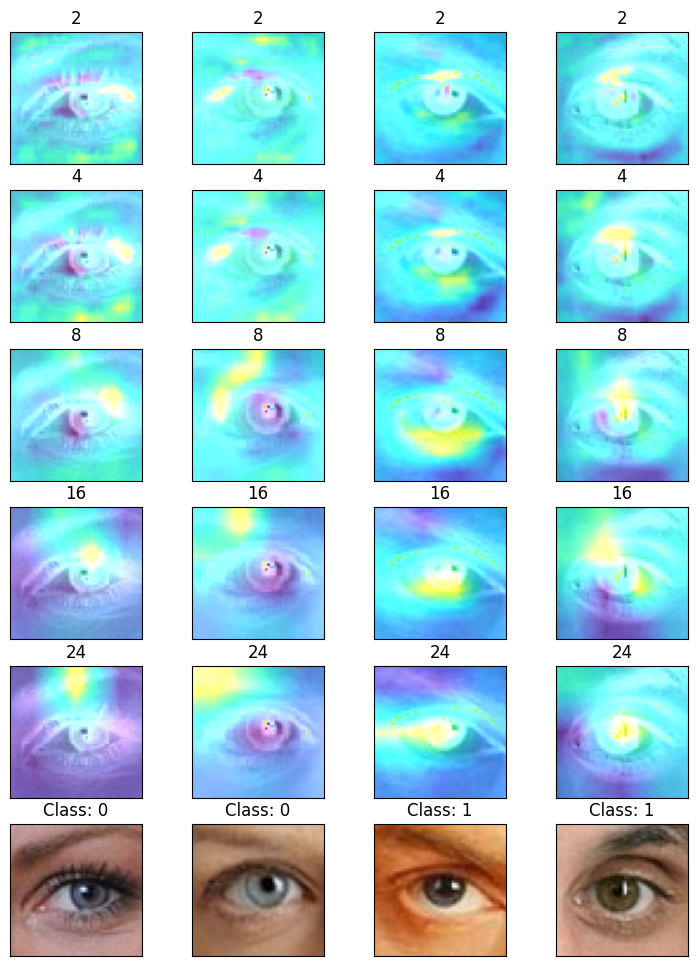

In [50]:
# List of unseen images to use. 2 Female, 2 Male.
unseen_eyes = ['./Data/Female/186.jpg',
               './Data/Female/2060.jpg',
               './Data/Male/186.jpg',
               './Data/Male/3154.jpg']

fig, ax = plt.subplots(6, 4, figsize = (9, 12))
# Iterate through the 4 random unseen eye images.
for i, file in enumerate(unseen_eyes):
    # From TF-Explain: https://github.com/sicara/tf-explain/blob/master/examples/core/occlusion_sensitivity.py
    img = tf.keras.preprocessing.image.load_img(file, target_size = (56, 56))
    img = tf.keras.preprocessing.image.img_to_array(img)

    explainer = OcclusionSensitivity()
    # Set index for correct class.
    class_index = 0 if i < 2 else 1

    # Iterate different patch sizes and plot.
    for j, patch in enumerate([2,4,8,16,24]):
        # Compute Occlusion Sensitivity at different patch sizes.
        explained = explainer.explain(([img], None), mod_cnn, class_index = class_index, patch_size = patch)
        ax[j, i].set_title(f'{patch}')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].imshow(explained)

    # Show original image at last row.
    img = Image.open(file)
    img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
    ax[5, i].imshow(img)
    ax[5, i].set_xticks([])
    ax[5, i].set_yticks([])
    ax[5, i].set_title(f'Class: {class_index}')
    
plt.show()

*Female = 0, Male = 1*

The two left columns are labeled as women and the two right columns are men.

Interestingly, and at least for this small sample, we can see some subtle difference in what features are being shown as important between the two classes. We can also see some changes in results as the occlusion patch size increase, thus showing results of the effects of larger features.

Female:
- Eyebrows are being highlighted more than in the male photos.
- Specifically the upper lid eyelashes are highlighted more here. Especially at the far corner of the eye.
- It may also weight the skin around the eye a little more for this class.

Male:
- A little upper eyelash highlight here as well.
- We also see a high amount of activation along the lower edge of the eye.
- Possibly more highlighting around the iris compared to the women.

This plot brings up a lot of questions and insights about how this model is classifying images. It is quite possible that there are subtle differences in the dataset that are effecting it's "decisions". For instance, it might be useful to explore how balanced the hair color and makeup use is between the two classes. It could be possible that mascara use in the women is allowing the models to heavily favor using this feature for classifying the images. Futhermore, since the source of these images are from a IMDB-esque website most of these images are likely either professional headshots or movie posters. These facts are likely introducing a large amount of bias into this dataset.

### 8.3. Model Embedding Principal Component Analysis (PCA): <a name="pca"></a>

Another valuable analysis tool is to extract the feature embeddings (layer outputs) and use Principal Component Analysis (PCA) to reduce the dimensions and plot the top two principal components. We can even plot each image on this PCA for an impressive visualization that might allow us to identify emerging complex patterns.

The images from the test set will be used for these plots and each image will be bordered with the color of the true class label (Female = Teal, Male = Purple). One version with the image and another as a scatter plot for easier visual parsing of the class distribution.

In [51]:
# Get feature vector from model.
def feature_extractor(model, layer_num):
    # https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction
    extractor = tf.keras.Model(inputs = model.inputs,
                            outputs = [layer.output for layer in model.layers])
    features_test = extractor(np.stack(X_test.norm_flat.apply(flat_to_array)))

    feature_vec_cnn = []
    # Take feature vector from layer_num.
    for i in range(len(X_test)):
        feature_vec_cnn.append(features_test[layer_num][i].numpy())
    
    return feature_vec_cnn

In [52]:
def pca_plot(features, image_arrays, zoom = 0.5, cmap = None, photos = True): #zoom = 0.125

    # Reduce dimensions to 2 using PCA.
    pca = PCA(n_components = 2)
    pca_fit = pca.fit_transform(features)
    print(f'Explained Variance Ratios: {pca.explained_variance_ratio_}')

    _, ax = plt.subplots(figsize = (20, 15), subplot_kw = {'aspect' : 'equal'})
    ax.scatter(pca_fit[:, 0], pca_fit[:, 1], c = cmap, alpha = 0.8)
    
    # Add eye photos to plot.
    if photos == True:
        for i, rgb_flat in enumerate(image_arrays):
            # Load image.
            image = Image.fromarray(rgb_flat.reshape(img_size,img_size,3))
            # Zoom out.
            im = OffsetImage(image, zoom = zoom)
            # Set class label color for edge bbox.
            bboxprops = ({'edgecolor' : cmap[i], 'lw' : 2} if cmap is not None else None)
            anno_bbox = AnnotationBbox(offsetbox = im, 
                                xy = pca_fit[i],
                                xycoords = 'data',
                                frameon = (bboxprops is not None),
                                pad = 0.075,
                                bboxprops = bboxprops)
            ax.add_artist(anno_bbox)

    ax.set_axis_off()
    ax.axis('tight')
    ax.set_title('Principal Component Analysis (PCA) of Eye Feature Embeddings')

    return ax

In [53]:
# Teal = Women, Purple = Men
cmap_sex_all = ['#439A86' if sex == 0 else '#423e80' for sex in y_test]

First from the CNN (section 7.2.2.) we can extract and visualize the resulting embeddings coming out of the last convolution block and into the first dense layer.

Above each plot is the layer number and which model's embedding is being shown. Also, the resulting top 2 principal component's explained variance ratios.

CNN - Layer 13
Explained Variance Ratios: [0.20404717 0.09216744]


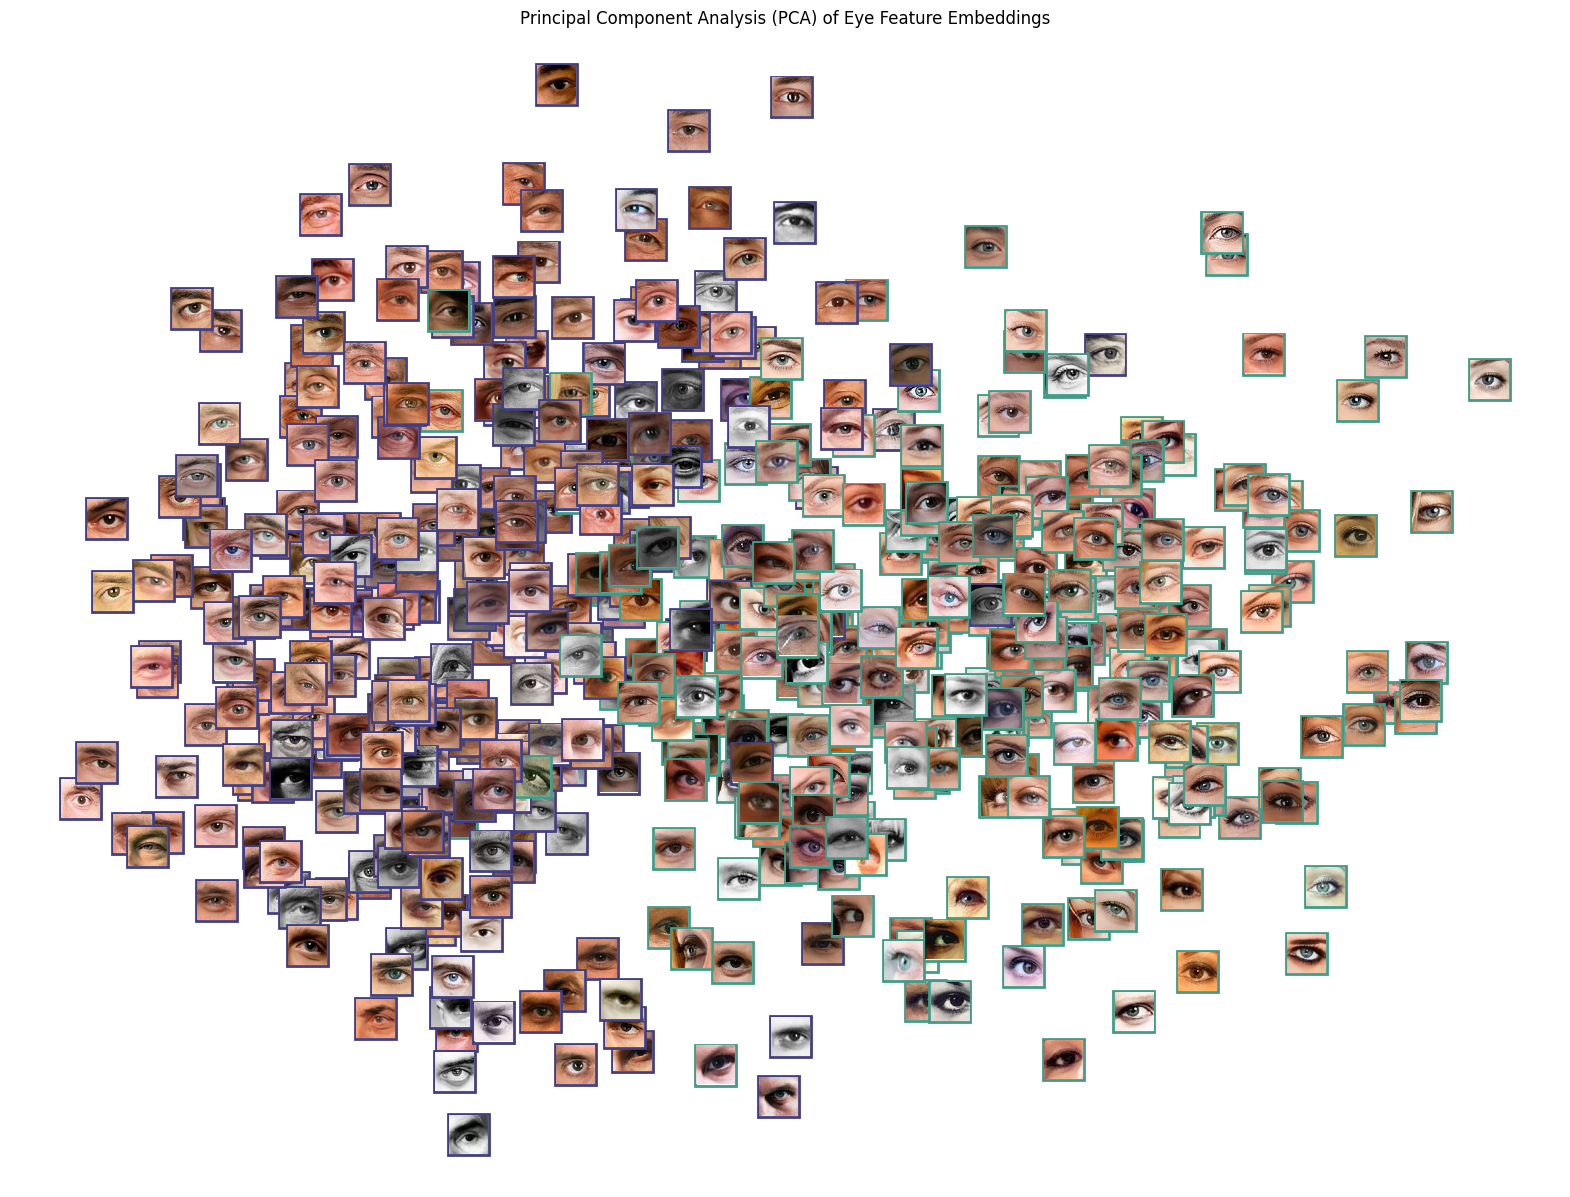

Explained Variance Ratios: [0.20404717 0.09216744]


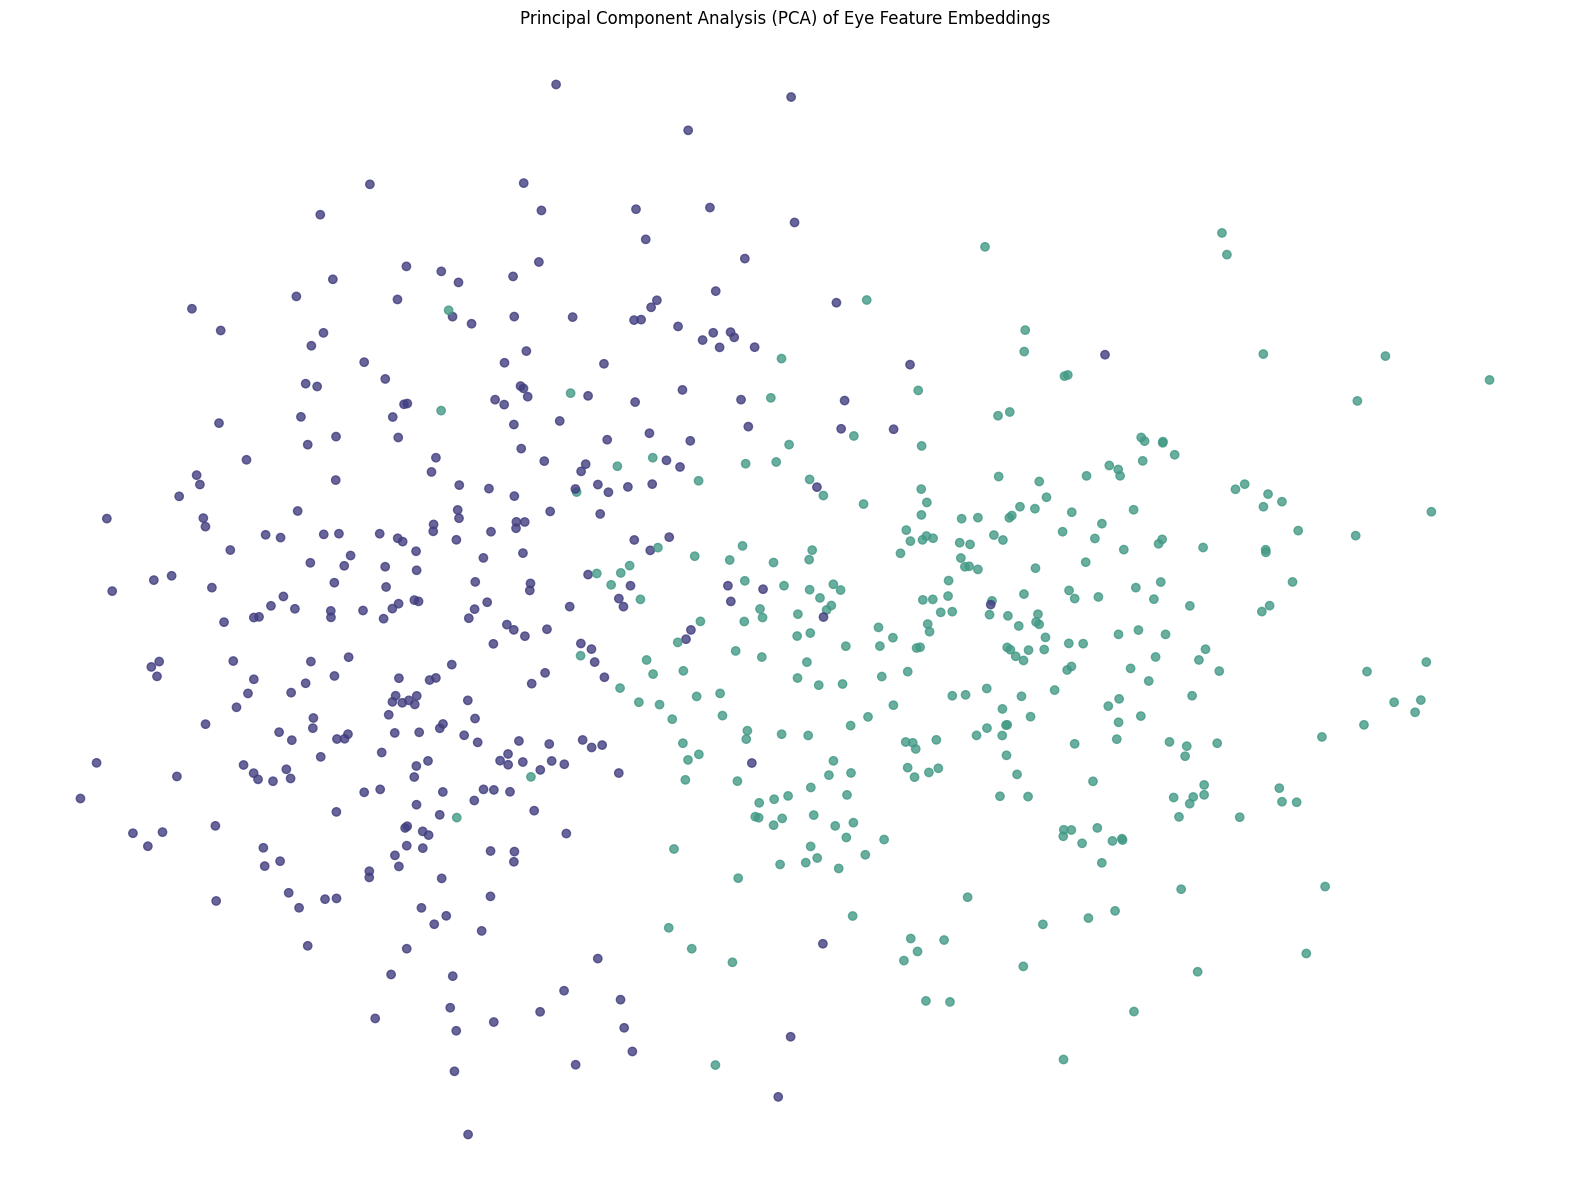

In [54]:
feature_vec_cnn = feature_extractor(mod_cnn, 13)

# Plot 2nd to last fully connected layer.
print('CNN - Layer 13')
_ = pca_plot(feature_vec_cnn, X_test.rgb_flat.tolist(), cmap = cmap_sex_all)
plt.show()

_ = pca_plot(feature_vec_cnn, X_test.rgb_flat.tolist(), cmap = cmap_sex_all, photos = False)
plt.show()

Identifying combine characteristics from principal components is a highly imprecise art, but I believe we can see a few things along each axis here.

- Along the x-axis is the class label, of course, with two easily identifiable clusters meeting and slightly overlapping at the center.
- The y-axis is a little more subtle, but here it seems the lower on the y-axis shows eyes with heavier dark features (eye shadow or mascara for the women or darker lighting or hair color for the men).

Now, we can do the same but on the last fully connected layer (dense) of the same model.

CNN - Layer 16
Explained Variance Ratios: [0.54373284 0.03505089]


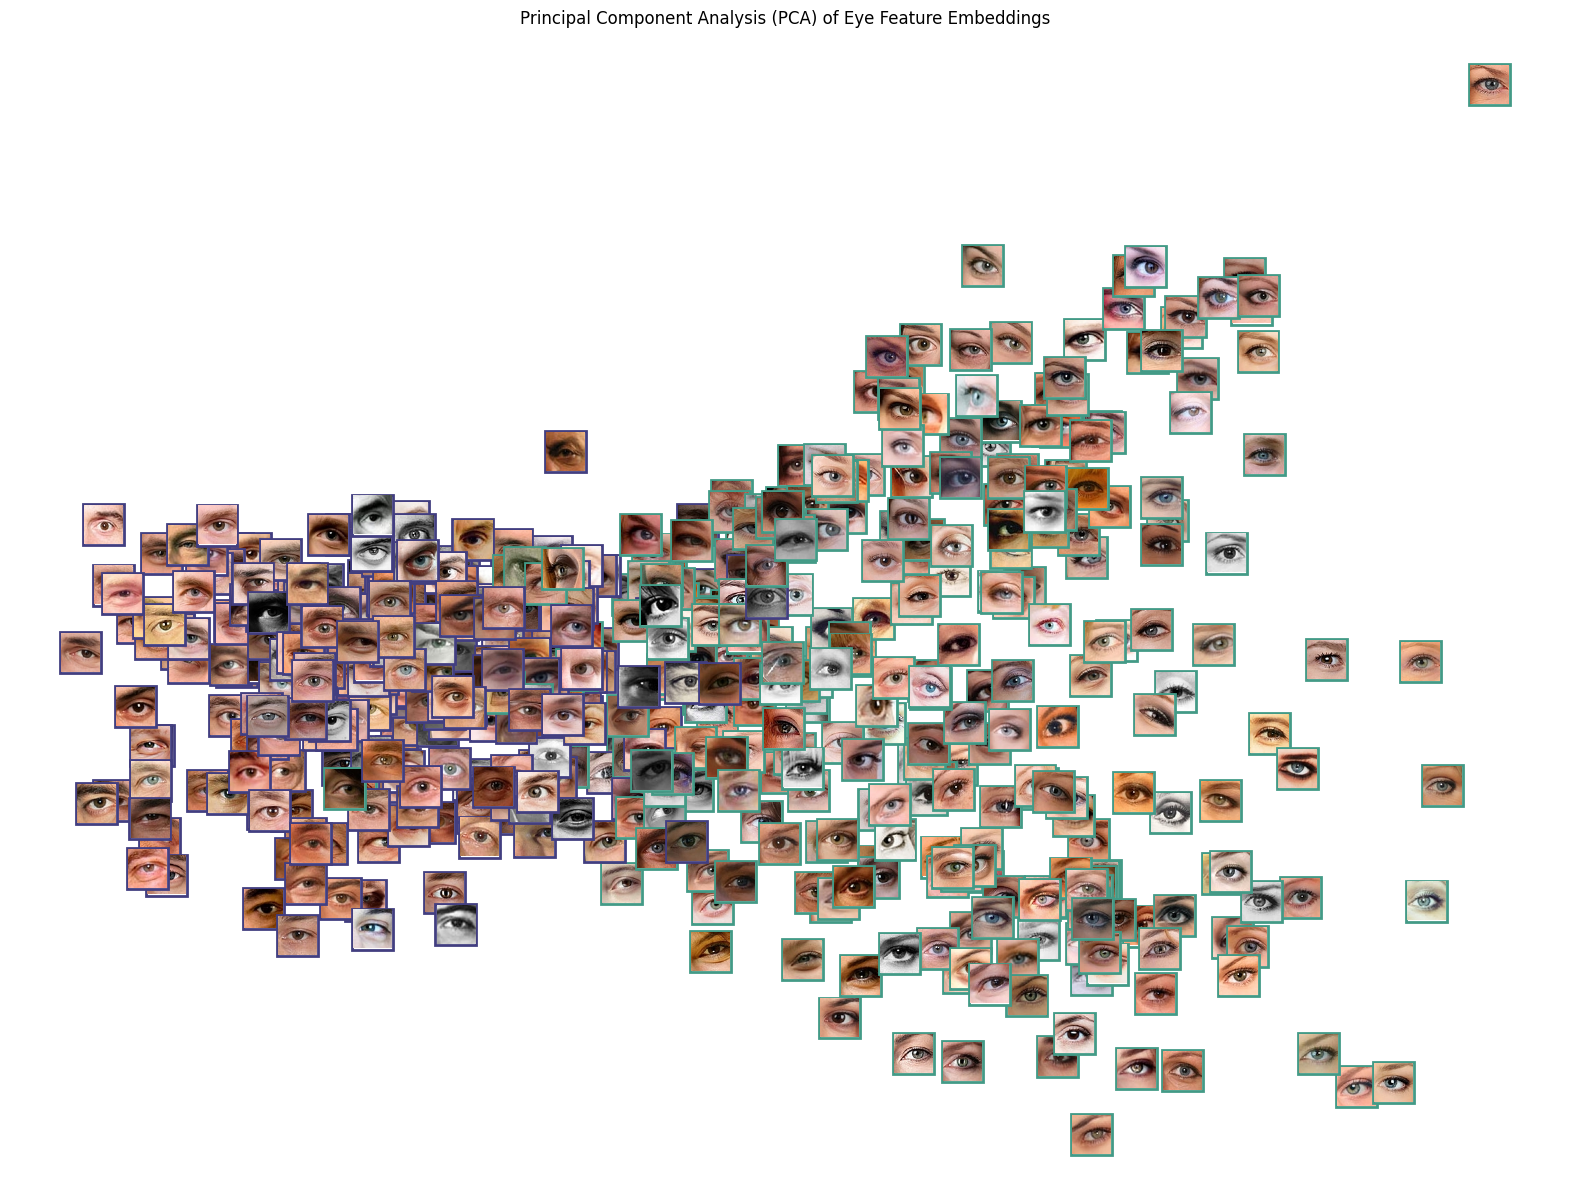

Explained Variance Ratios: [0.54373284 0.03505089]


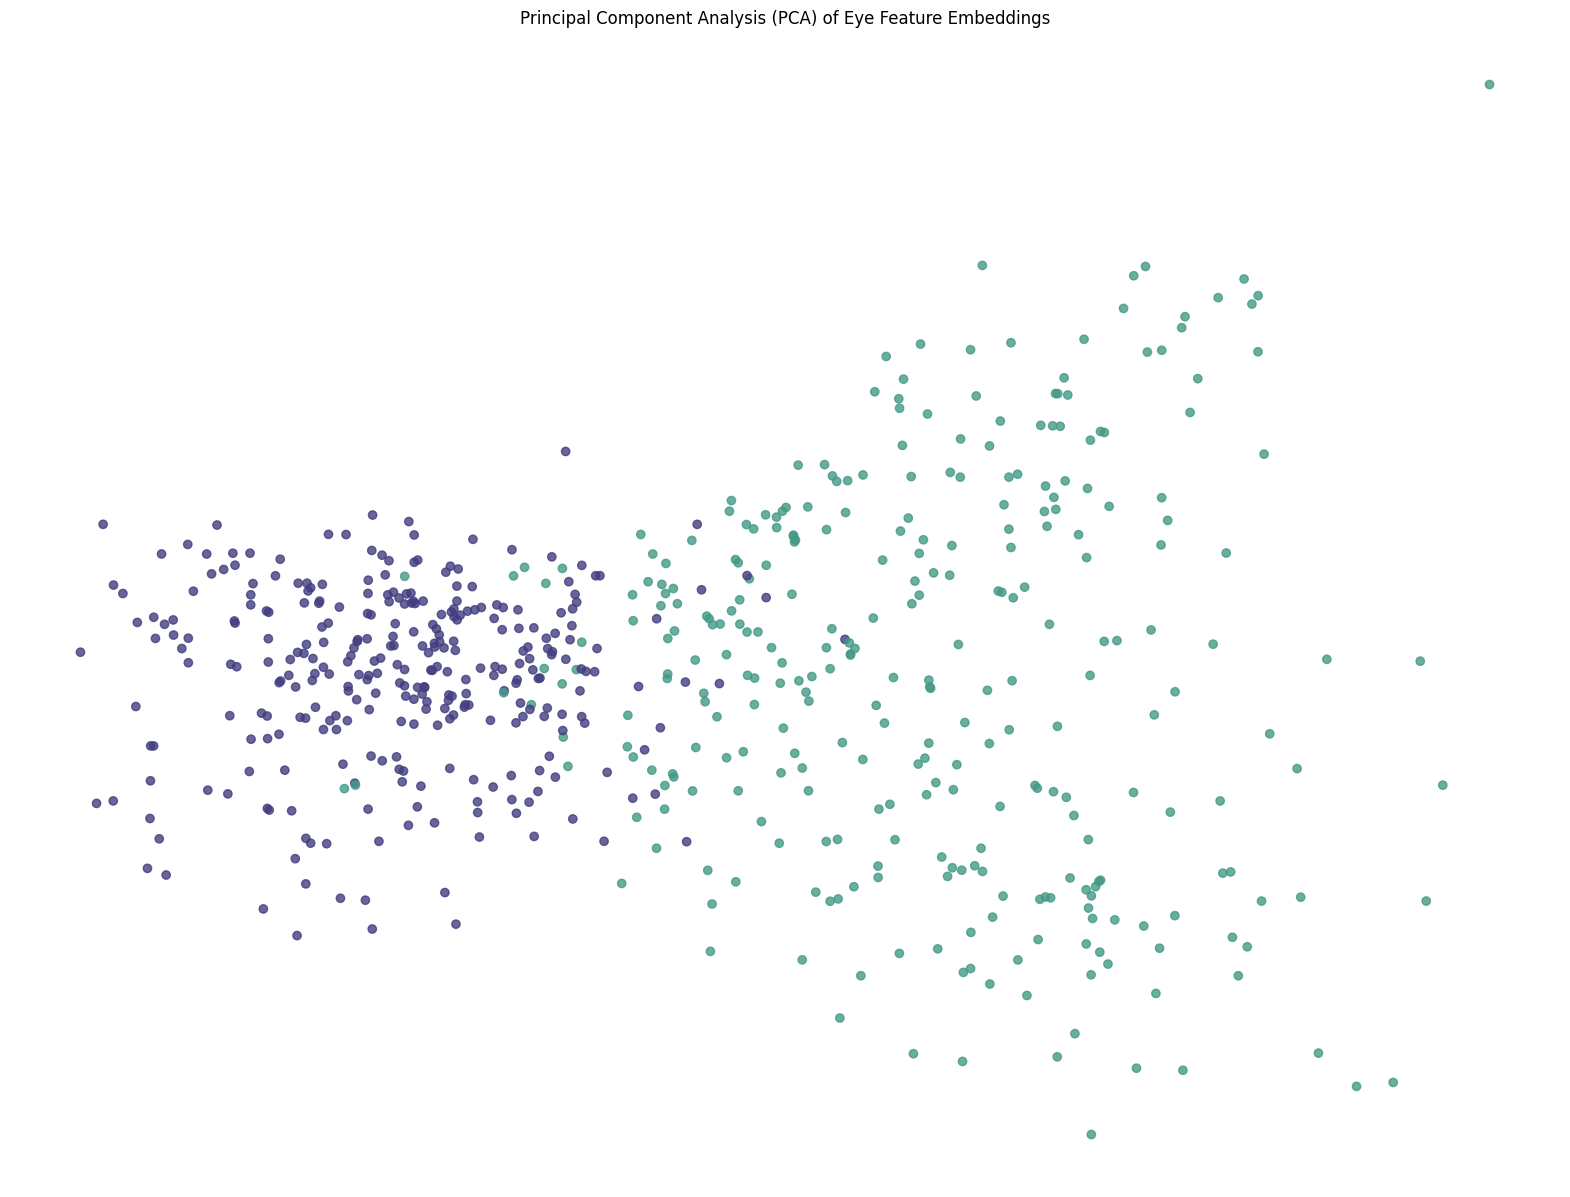

In [55]:
feature_vec_cnn = feature_extractor(mod_cnn, 16)

# Plot the last fully connected layer PCA.
print('CNN - Layer 16')
_ = pca_plot(feature_vec_cnn, X_test.rgb_flat.tolist(), cmap = cmap_sex_all)
plt.show()

_ = pca_plot(feature_vec_cnn, X_test.rgb_flat.tolist(), cmap = cmap_sex_all, photos = False)
plt.show()

The difference between this and the previous is drastic and the two clusters seem to have put more distance between them. Oddly we can see a new prevailing feature along the y-axis here.

- On the y-axis, we now see that low y values show images of individual's left eye while higher on the y-axis are right eyes. Oddly I don't see this to be the case for the Males.
- The men have a much more dense cluster showing little variance in distance along both axis.


Now to do the same thing but with the DCNN (section 7.2.3.). We will be extracting the output from the `GlobalAveragePooling2D` layer near the bottom of the network before prediction.

DCNN - Layer -2
Explained Variance Ratios: [0.77782455 0.10590087]


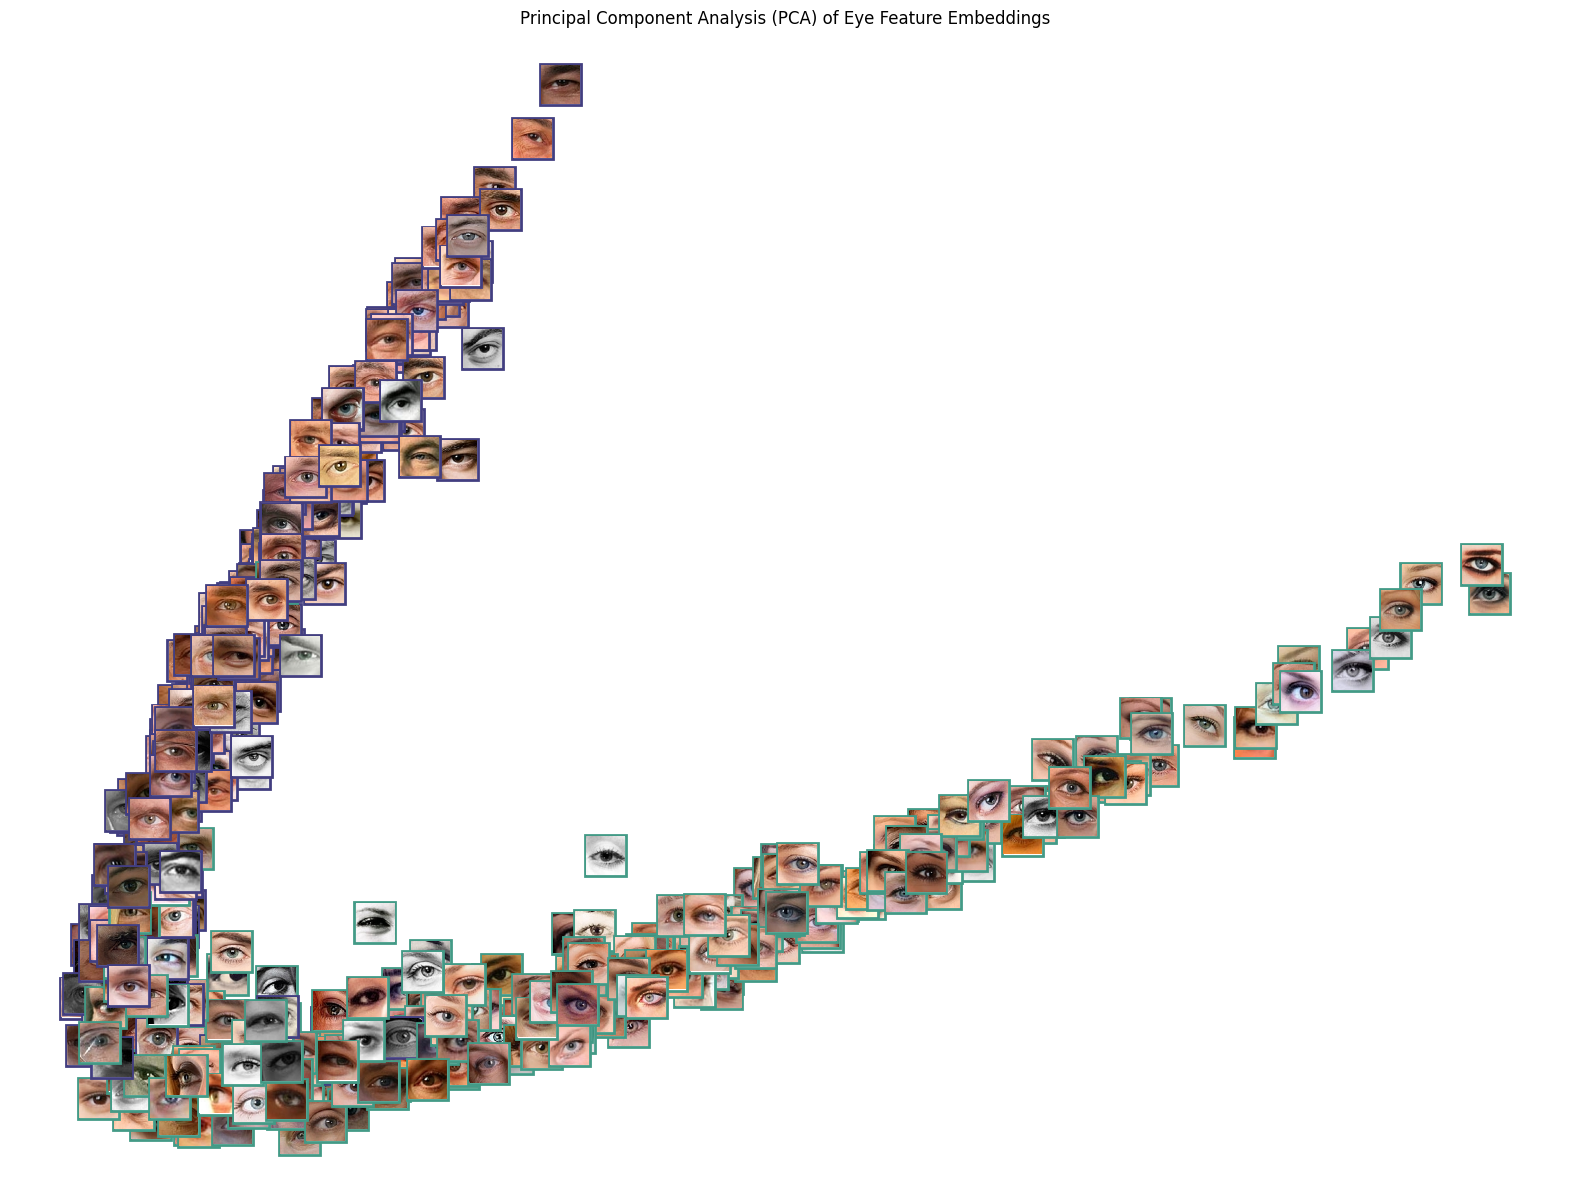

Explained Variance Ratios: [0.77782455 0.10590087]


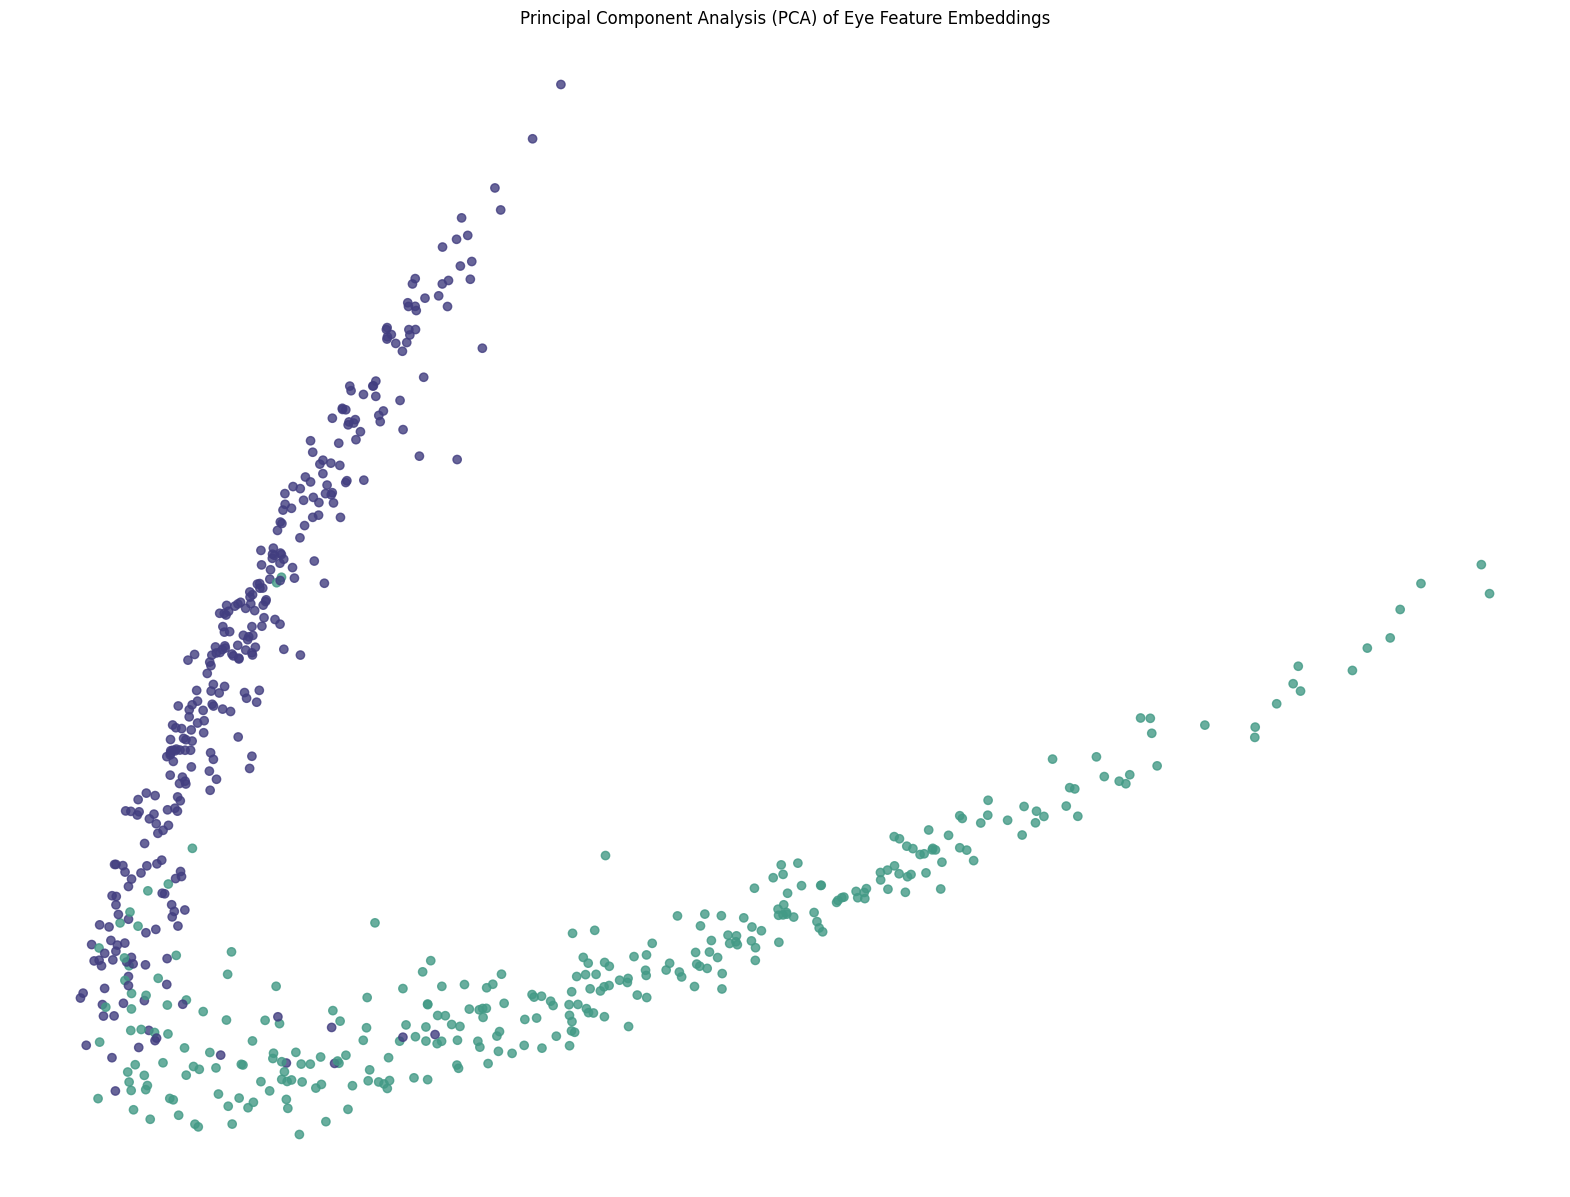

In [56]:
feature_vec_dcnn = feature_extractor(mod_dcnn, -2)

print('DCNN - Layer -2')
# Plot global pool layer.
_ = pca_plot(feature_vec_dcnn, X_test.rgb_flat.tolist(), cmap = cmap_sex_all)
plt.show()

_ = pca_plot(feature_vec_dcnn, X_test.rgb_flat.tolist(), cmap = cmap_sex_all, photos = False)
plt.show()

The explained variance ratios a show an impressive ~87% between the two components and its easy to see that by how structured this PCA plot turned out. The easiest learners are at the edge of the long swooping shape.

### 8.4. Misclassification Exploration: <a name="misclass"></a>

It can be useful to examine the images that were misclassified and see if there are any obvious image differences or correlations between them that might give insights into why the model is misclassifying them.

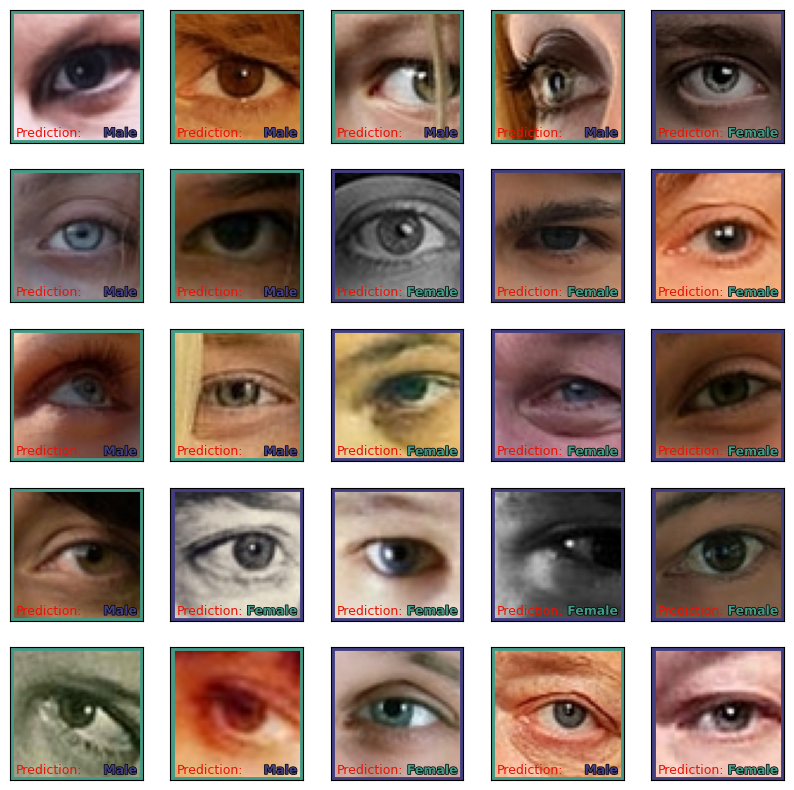

In [153]:
# Get mask for all misclassified images in test set.
mask_missed_cnn = y_test != y_pred_cnn
# Sample 25 images from misclassified images.
missed_real_labels = y_test[mask_missed_cnn].sample(25, random_state = 11)

cmap_sex_missed = ['#439A86' if sex == 0 else '#423e80' for sex in missed_real_labels]
class_map = {0: 'Female', 1: 'Male'}

fig, ax = plt.subplots(5, 5, figsize = (10,10))
# Use index to retrieve images and loop through.
for i, img in enumerate(X_test.loc[missed_real_labels.index].rgb_flat):
    ax[i//5, i%5].set_xticks([])
    ax[i//5, i%5].set_yticks([])
    ax[i//5, i%5].imshow(flat_to_array(img))
    # Add border for real label.
    border = plt.Rectangle((0, 0), 55, 55,
                           fill = False,
                           color = cmap_sex_missed[i],
                           linewidth = 3.5)
    ax[i//5, i%5].add_patch(border)
    # Add text for incorrect predictions.
    ax[i//5, i%5].text(2, 53, 'Prediction:', fontsize = 9, color = '#e61405')
    ax[i//5, i%5].text(53, 53, (f"{class_map[1 - missed_real_labels.iloc[i]]}"),
                       fontsize = 9, 
                       weight = 'bold',
                       ha = 'right', 
                       color = cmap_sex[class_map[1 - missed_real_labels.iloc[i]]]
                       ).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                           path_effects.Normal()])
plt.show()

**Real Label:** The colored border of the image indicates the real class, consistent with all other visualizations.

- Teal = Female
- Purple = Male

**Predicted Label:** The text printed on the image.

Looking through these sampled 25 (out of 29) of misclassified images, many of them share a few common characteristics.

- Hair
- Age (wrinkles)
- Weird angles
- Glasses
- Subtle eyelashes
- No eyebrows

Besides the obvious issues like the images with hair obscuring the eyes and images taken at odd angles, there likely aren't enough images in the training data that represent older individuals or people with glasses. There also seem to be quite a few examples of people with light colored or hard to see eyelashes. These hard learners (and others) might benefit from higher resolution images.

### 8.5. Predict for Fun: <a name="fun"></a>

Now, it seems like a missed opportunity to not attempt to predict on some personal photos. 

Below I will import a periocular image of myself and my wife. We both present as Male and Female respectively. Let's see if my model can correctly classify us as such.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


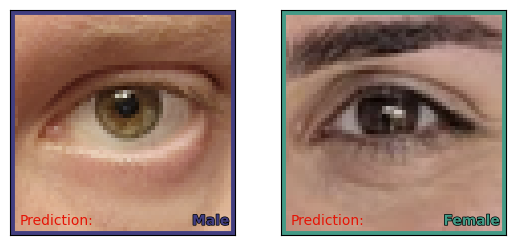

In [159]:
# Import prediction images for fun.
predict_files = os.listdir('./Data/Predict/')

fig, ax = plt.subplots(1, len(predict_files))
for i, img in enumerate(predict_files):
    img = Image.open(f'./Data/Predict/{img}')
    img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
    img = img.convert('RGB')
    img = np.asarray(img)
    img = np.expand_dims(img, axis = 0)
    ax[i].imshow(img[0,:,:,:])
    # Predict image class.
    predict_proba = mod_cnn.predict(img, verbose = "auto", callbacks = None)
    predict = predict_proba.argmax(axis = 1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    # Add border for real label.
    border = plt.Rectangle((0, 0), 55, 55, fill = False, color = cmap_sex[class_map[predict[0]]], linewidth = 3.5)
    ax[i].add_patch(border)
    ax[i].text(2, 53, 'Prediction:', fontsize = 10, color = '#e61405')
    ax[i].text(54, 53, (f"{class_map[predict[0]]}"), fontsize = 10, weight = 'bold', ha = 'right', 
                       color = cmap_sex[class_map[predict[0]]]
                       ).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                           path_effects.Normal()])
plt.show()

Well, no gender-bending surprises there, the model works great!

## 9. Results <a name="results"></a>

---

Finally, we can check the performance of each model on the test set.

In [58]:
# Plot confusion matrices of all models.
def confusion_matrix_subplot(y_pred_dict):
    model_class_vals = {}

    fig, ax = plt.subplots(int(np.ceil(len(y_pred_dict) / 2)), 2, figsize = (7, 7), sharey = True)
    for i, (model, y_pred) in enumerate(y_pred_dict.items()):
        y_true = y_test

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm)
        disp.plot(ax = ax[i//2, i%2])
        disp.ax_.set_title(str(model))
        disp.im_.colorbar.remove()
        # Store classification metrics
        # In the order [tn, fp, fn, tp]
        model_class_vals[model] = list(confusion_matrix(y_true, y_pred, labels = y_true.unique().sort()).ravel())

    # Check if odd number of models and delete last subplot if true.
    if len(y_pred_dict) % 2 != 0:
        fig.delaxes(ax[i//2, (len(y_pred_dict) % 3)])
    fig.tight_layout()
    plt.subplots_adjust(wspace = 0.2, hspace = 0)
    fig.colorbar(disp.im_, ax = ax)
    fig.suptitle('Confusion Matrices of All Models')
    
    return model_class_vals

# Plot all model ROC curves.
def roc_curve_subplot(y_pred_proba_dict):
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    for i, model in enumerate(y_pred_proba_dict.keys()):
        y_pred_proba_temp = y_pred_proba_dict[model][:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_temp)
        auc_score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = f"AUC = {auc_score:0.3f} | {model}", alpha = 0.8)

    # Add 45 degree line for 0.5 AUC.
    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')

    ax.set_title('Test Set - ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    plt.grid(alpha = 0.4)
    plt.legend(loc = 'center right')

    plt.show()

# Highlight the best model's test results green at each proportion.
def max_value_highlight(df):
    max_test_rows = df.max()
    is_max = (df == max_test_rows)
    
    return ['background-color:green' if v else '' for v in is_max]

# Highlight the top two results in each column blue so that 2nd place is in blue after .apply().
def highlight_top_two(df):
    # Sort values
    sorted_df = df.sort_values(ascending = False)
    top_two = sorted_df.iloc[:2]
    # Mask
    is_top_two = df.isin(top_two)

    return ['background-color: blue' if v else '' for v in is_top_two]

For convenience, we can store the prediction arrays in dictionaries to be iterated over within the functions above.

In [59]:
y_pred_dict = {'KNN': y_pred_knn,
               'FNN': y_pred_fnn,
               'CNN': y_pred_cnn,
               'DCNN': y_pred_dcnn}

y_pred_proba_dict = {'KNN': y_pred_knn_proba,
                     'FNN': y_pred_fnn_proba,
                     'CNN': y_pred_cnn_proba,
                     'DCNN': y_pred_dcnn_proba}

y_pred_val_dict = {'KNN': y_pred_val_knn,
               'FNN': y_pred_val_fnn,
               'CNN': y_pred_val_cnn,
               'DCNN': y_pred_val_dcnn}

y_pred_no_aug_dict = {'KNN': y_pred_knn,
               'FNN': y_pred_fnn_no_aug,
               'CNN': y_pred_cnn_no_aug,
               'DCNN': y_pred_dcnn_no_aug}

y_pred_val_no_aug_dict = {'KNN': y_pred_val_knn,
               'FNN': y_pred_val_fnn_no_aug,
               'CNN': y_pred_val_cnn_no_aug,
               'DCNN': y_pred_val_dcnn_no_aug}

Here I can plot a confusion matrix for each model.

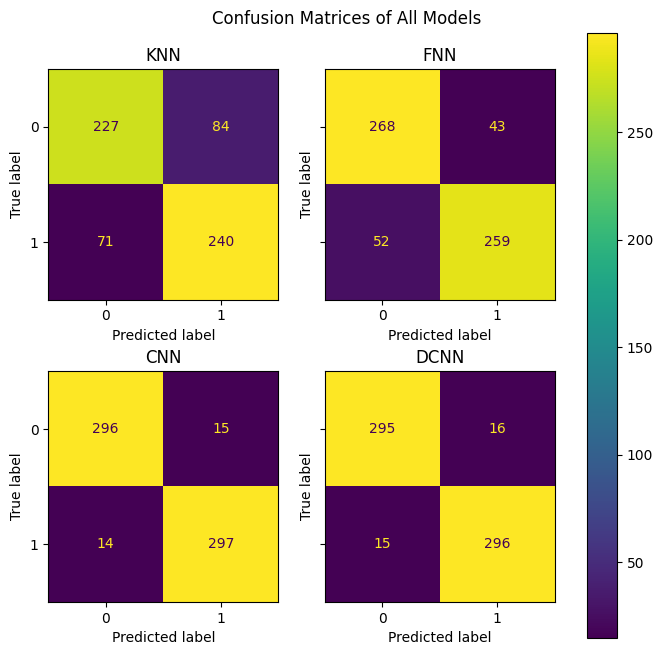

In [60]:
model_class_vals = confusion_matrix_subplot(y_pred_dict)

The performance of the CNN and DCNN are almost the same, though the CNN edges out the DCNN here just barely on the test set (which was the opposite on the validation set). It is also surprising to see that the two CNN-based models perform about equally on each class.

KNN:
- 155 misclassifications, more women than men.

FNN:
- 95 misclassifications, more men than women.

CNN:
- 29 misclassifications, about equal.

DCNN:
- 31 misclassifications, about equal.

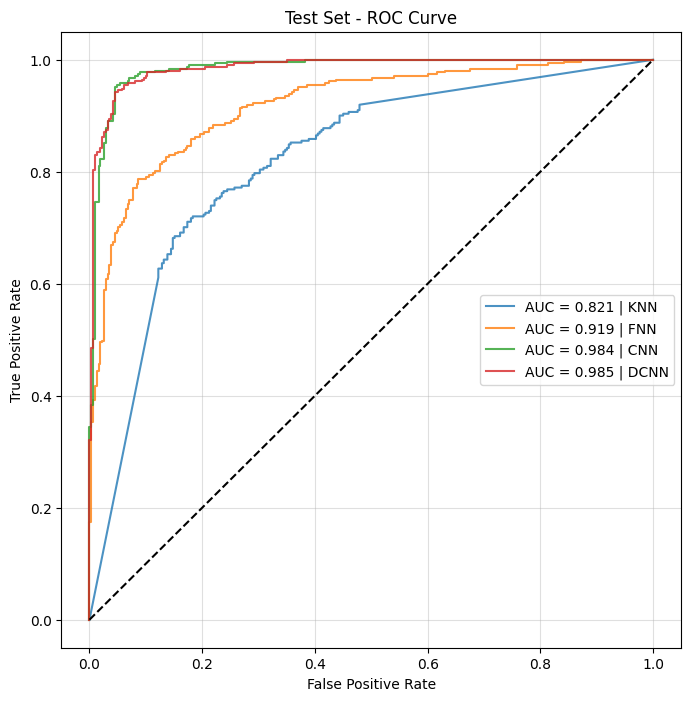

In [61]:
roc_curve_subplot(y_pred_proba_dict)

The Area Under the Curve (AUC) scores of each of the models shows the same story here -- though the DCNN just edged out the CNN, but in reality the both performed about the same on the test set.


Now let's calculate the accuracy of each model and output the results into a dataframe. Also, we will evaluate each model on the non-augmented training dataset.

Accuracy was chosen because the dataset was class balanced and that was maintained through splitting into testing and validation sets as well.

In [62]:
# Non-augmented training images.
results_no_aug_dict = {}
for model, y_pred in y_pred_no_aug_dict.items():
        val_acc = accuracy_score(y_val, y_pred_val_no_aug_dict[model])
        test_acc = accuracy_score(y_test, y_pred)
        results_no_aug_dict[model] = [val_acc, test_acc]

results_no_aug_df = pd.DataFrame().from_dict(results_no_aug_dict, orient = 'index', columns = ['Val Accuracy', 'Test Accuracy'])
results_no_aug_df = pd.concat([pd.DataFrame({'Val Accuracy': 0.5, 'Test Accuracy': 0.5}, index = ['Random Baseline']), results_no_aug_df])
results_no_aug_df.loc['KNN'] = [0, 0]
#results_no_aug_df.style.apply(highlight_top_two).apply(max_value_highlight)

# Augmented training images.
results_dict = {}
for model, y_pred in y_pred_dict.items():
        val_acc = accuracy_score(y_val, y_pred_val_dict[model])
        test_acc = accuracy_score(y_test, y_pred)
        results_dict[model] = [val_acc, test_acc]

results_df = pd.DataFrame().from_dict(results_dict, orient = 'index', columns = ['Val Accuracy', 'Test Accuracy'])
results_df = pd.concat([pd.DataFrame({'Val Accuracy': 0.5, 'Test Accuracy': 0.5}, index = ['Random Baseline']), results_df])
#results_df.style.apply(highlight_top_two).apply(max_value_highlight)

In [63]:
results_concat = pd.concat([results_df, results_no_aug_df], axis = 1)
results_concat.columns = pd.MultiIndex.from_tuples(zip(['Augmented', 'Augmented.', 'Not Augmented', 'Not Augmented.'], results_concat.columns))
results_concat.style.apply(highlight_top_two).apply(max_value_highlight)

In each column, the best metric is highlighted in green and second best is blue. The two left columns are the models trained with the image augmentations and the two right columns are without augmentation.

First looking at the models trained using image augmentations:
- Again, the CNN and DCNN are performing almost exactly the same, switching between the validation and test sets.
- The CNN outperforms the DCNN on the test set by ~0.3% with a test accuracy of ~95.34%.
- The DCNN performed 2nd best with an accuracy score of ~95.02%.
- Each model outperformed the KNN baseline and random chance metrics.

Non-Augmented:
- The FNN performs better on the non-augmented training images. This makes sense because the FNN, using only dense layers, is not invariant to image transformations and the images from the unaltered dataset are roughly located in the same location/orientation. Thus, the FNN struggles to generalize between a more diverse dataset in a computer vision context.
- The CNN performs the best of all the models with this unaltered data, but worse here than when using the augmented images.
- The DCNN accuracy scores fell 4-7% between the augmented and non-augmented datasets. This much deeper model benefits from the much (effectively) larger and diverse dataset that the augmented training images provides.

## 10. Conclusion <a name="conclusion"></a>

---

The results and analysis from this project demonstrate the effectiveness of deep convolutional neural networks (DCNNs) for classifying sex based on periocular images. An accuracy score of ~95% for sex identification from low-resolution 56 x 56 images shows promising results.

**Some key takeaways from this project:**

**DCNN Efficacy:** By training models of various architectures, it confirms that DCNNs can extract essential features from the periocular region to differentiate between sexes, even with shallower networks. The deep models displayed robust performance, especially after fine-tuning, and random image augmentation of the training data.

**Feature Extraction Insights:** In-depth analysis of model filters and feature maps revealed that certain filters in the early convolutional layers focused on basic visual features such as edges and textures, while deeper layers captured more complex patterns and structures relating to the eye and periocular region. The hierarchical layering of the network's architectures yield effective feature extraction and accurate sex classification. By visualizing convolutional layer filters, it was observed that the model learned distinct features which contributed to classification performance.

**Data Augmentation's Impact:** CNN-based models trained with image augmentation outperformed those without augmentation, showcasing improved generalization and reduced overfitting by adding size and diversity to the dataset. This was particularly evident because the dataset's size is relatively small for deep learning applications.

Not only were the models effective at sex classification using periocular images, but valuable insights were gained by exploring the feature extractions, revealing how networks process periocular images. The comparison of models with and without data augmentation also highlight the importance of using a sufficiently large and diverse dataset in deep learning. This project represents a strong first step in sex classification using eye images and informs the next steps for further understanding this task.

### 10.1. Limitations: <a name="limitations"></a>

- The analysis from section 8 raises important questions about how the model is classifying eye images, suggesting that subtle dataset differences may be influencing its decisions. For example, it may be worth investigating whether hair color and makeup such as mascara in women's images could be a dominant feature for classification. 
- The dataset presents a likely heavily biased distribution of not only eye presentations (makeup, Photoshop touchups, etc), but also a skewed distribution in age of the individual.
- Image resolution. Higher resolution images would likely improve performance and allow further analysis of features extracted.

### 10.2. Future Work: <a name="future"></a>

- A larger dataset would help alleviate some of the issues described above and possibly help models classify those hard misclassified examples.
- Find or compile a higher resolution dataset.
- Instead of using images of the periocular region, segment the iris and attempt to classify only using that masked segmentation. This has been shown to work but many current studies show biased methodologies and end with conflicting conclusions on this subject. It seems data leakage, poor segmentation leading to other characteristics to bleed into the models, tends to be the biggest issue with current studies.
- Further explore model interpretability to better understand whether the model is relying heavily on gender characteristics in the periocular region.
    - Perform more tests to confound these models to determine how much weight is given to characteristics like makeup or eyelash contrast vs eye and eyebrow shape.

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

1. 2016 paper iris sex classification based on in-depth feature selection and SVM: https://ieeexplore.ieee.org/abstract/document/7447785
2. 2018 paper iris sex classification based on Zernike moments and classifying using SVM and KNN: https://ieeexplore.ieee.org/document/8492757
3. 2019 paper iris .. using CNNs and image augmentation: https://ieeexplore.ieee.org/abstract/document/7447785
4. 2023 paper classifcation using periocular region and iris using pre-trained CNNs and transfer learning: https://www.sciencedirect.com/science/article/pii/S2666307423000268
5. 2019 Paper refuting previous papers claims on classifications based solely on iris; claiming periocular features were included: https://ieeexplore.ieee.org/document/8659186
6. Great examples of utilizing matplotlib to plot PCA/t-SNE tied to their images https://www.kaggle.com/code/hmendonca/proper-clustering-with-facenet-embeddings-eda
7. Local Binary Patterns used for feature extraction: https://en.wikipedia.org/wiki/Local_binary_patterns
8. Sobel filter edge detector: https://en.wikipedia.org/wiki/Sobel_operator

Alternative Datasets that would improve this project and allow for more nuanced segmentation of eye features:
1. Biometrics Research of Notre Dame has a high quality dataset. Behind a license application: https://cvrl.nd.edu/projects/data/
2. Another dataset with high-resolution iris photos. Behind license and too big for this project, though: https://ieee-dataport.org/documents/iris-super-resolution-dataset

Exported to HTML via command line using:

- `jupyter nbconvert Periocular_Sex_Classification.ipynb --to html`
- `jupyter nbconvert Periocular_Sex_Classification.ipynb --to html --HTMLExporter.theme=dark`